## Install Essential Libraries

Create a cell that checks for and installs required libraries if not already installed.

In [293]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [295]:
# Ensure essential libraries are installed
import sys
import subprocess

def install(package):
    if package not in sys.modules:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of essential libraries
required_libraries = [
    "pandas", "numpy", "nltk", "spacy", "datasets",
    "scikit-learn", "matplotlib", "seaborn", "umap-learn","gensim"
]

# Install each library
for lib in required_libraries:
    install(lib)

# Download Spacy model
try:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
except Exception as e:
    print(f"Spacy model already downloaded or error occurred: {e}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.4 MB/s eta 0:00:00a 0:00:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Load Libraries

After ensuring all required libraries are installed, load them in the next cell.

In [298]:
# Load essential libraries
import pandas as pd
import numpy as np
import nltk
import spacy
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from gensim import corpora
# Download stopwords and other NLTK data
nltk.download("stopwords")
nltk.download("punkt")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nimathing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nimathing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Preprocessing: 

### a. Loading the Data

In [300]:
# Load episode-level data sample
episode_data = pd.read_json('podcast/episodeLevelDataSample.jsonl', lines=True)

# Load speaker-turn-level data sample
speaker_turn_data = pd.read_json('podcast/speakerTurnDataSample.jsonl', lines=True)


### b. Loading the Data (Optional)

> **Note:** The following lines are for loading datasets via Google Drive. 
> They are required to run in **Google Colab** but **do not work in Jupyter Notebook.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



In [226]:
import pandas as pd
import gzip

def read_gzip_jsonlines(filepath, nrows=None):
    """Reads a gzip-compressed JSON Lines file into a Pandas DataFrame, with an option to limit the number of rows.

    Args:
        filepath (str): The path to the gzip-compressed JSON Lines file.
        nrows (int, optional): The maximum number of rows to read. Defaults to None (read all rows).

    Returns:
        pandas.DataFrame: The DataFrame containing the JSON data, or None if an error occurs.
    """
    try:
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            # Use pandas read_json with the "lines=True" option and limit rows using nrows
            df = pd.read_json(f, lines=True, chunksize=1000)  # Read in chunks of 1000 lines
            data = []
            rows_loaded = 0
            for chunk in df:
                data.append(chunk)
                rows_loaded += len(chunk)
                if nrows and rows_loaded >= nrows:
                    break
            # Combine chunks into a single DataFrame
            final_df = pd.concat(data)[:nrows]  # Ensure we don't exceed nrows
            return final_df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except gzip.BadGzipFile:
        print(f"Error: Invalid gzip file at {filepath}")
        return None
    except pd.errors.ParserError as e:
        print(f"Error parsing JSON: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

nrows=20000
# Load the first 20,000 rows of episode-level data
episode_data = read_gzip_jsonlines('podcast/episodeLevelData.jsonl.gz', nrows)

if episode_data is not None:
    print(f'\n Episode Data (First {nrows} Rows) Loaded Successfully:')
    print(episode_data.head())  # Print the first few rows

# Load the first 20,000 rows of speaker-turn-level data
speaker_turn_data = read_gzip_jsonlines('podcast/speakerTurnData.jsonl.gz', nrows)

if speaker_turn_data is not None:
    print(f"\nSpeaker Turn Data (First {nrows} Rows) Loaded Successfully:")
    print(speaker_turn_data.head())  # Print the first few rows



 Episode Data (First 20000 Rows) Loaded Successfully:
                                          transcript  \
0   I'm Simon Shapiro and this is Sing Out Speak ...   
1   I'm Simon Shapiro and this is Sing Out Speak ...   
2   I'm Simon Shapiro and this is Sing Out Speak ...   
3   I'm Simon Shapiro and this is Sing Out Speak ...   
4   I'm Simon Shapiro and this is Sing Out Speak ...   

                                    rssUrl                        epTitle  \
0  https://feeds.buzzsprout.com/783020.rss  Best of SingOut SpeakOut No.3   
1  https://feeds.buzzsprout.com/783020.rss                  It's All Gone   
2  https://feeds.buzzsprout.com/783020.rss             Today Is Yesterday   
3  https://feeds.buzzsprout.com/783020.rss                  Saturn Return   
4  https://feeds.buzzsprout.com/783020.rss             Quarterlife Crisis   

                                       epDescription  \
0  <p>Best of with snippets from 3 episodes and a...   
1  <p>Simon introduces &apos;It&a

### b. Exploratory Data Analysis (EDA)

#### 1. Overview of the Data


**Check Basic Information**

In [303]:
print(episode_data.info())
print(speaker_turn_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transcript             10000 non-null  object 
 1   rssUrl                 10000 non-null  object 
 2   epTitle                10000 non-null  object 
 3   epDescription          9717 non-null   object 
 4   mp3url                 10000 non-null  object 
 5   podTitle               9993 non-null   object 
 6   lastUpdate             10000 non-null  int64  
 7   itunesAuthor           9994 non-null   object 
 8   itunesOwnerName        9830 non-null   object 
 9   explicit               10000 non-null  int64  
 10  imageUrl               9994 non-null   object 
 11  language               10000 non-null  object 
 12  createdOn              10000 non-null  int64  
 13  host                   10000 non-null  object 
 14  podDescription         9989 non-null   object 
 15  cat

**Preview the Data**

In [306]:
episode_data.head()

transcript  \
0   I'm Simon Shapiro and this is Sing Out Speak ...   
1   I'm Simon Shapiro and this is Sing Out Speak ...   
2   I'm Simon Shapiro and this is Sing Out Speak ...   
3   I'm Simon Shapiro and this is Sing Out Speak ...   
4   I'm Simon Shapiro and this is Sing Out Speak ...   

                                    rssUrl                        epTitle  \
0  https://feeds.buzzsprout.com/783020.rss  Best of SingOut SpeakOut No.3   
1  https://feeds.buzzsprout.com/783020.rss                  It's All Gone   
2  https://feeds.buzzsprout.com/783020.rss             Today Is Yesterday   
3  https://feeds.buzzsprout.com/783020.rss                  Saturn Return   
4  https://feeds.buzzsprout.com/783020.rss             Quarterlife Crisis   

                                       epDescription  \
0  <p>Best of with snippets from 3 episodes and a...   
1  <p>Simon introduces &apos;It&apos;s all Gone&a...   
2  <p>Simon introduces track 4, of the newly rele...   
3  <p>This week, Simon introduces track 2- Saturn...   
4  <p>Big news week. The band Simon lived in the ...   

                                              mp3url          podTitle  \
0  https://www.buzzsprout.com/783020/4252475-best...  SingOut SpeakOut   
1  https://www.buzzsprout.com/783020/4165286-it-s...  SingOut SpeakOut   
2  https://www.buzzsprout.com/783020/3983942-toda...  SingOut SpeakOut   
3  https://www.buzzsprout.com/783020/3892169-satu...  SingOut SpeakOut   
4  https://www.buzzsprout.com/783020/3791501-quar...  SingOut SpeakOut   

   lastUpdate   itunesAuthor itunesOwnerName  explicit  ...  \
0  1607561074  Simon Shapiro   Simon Shapiro         0  ...   
1  1607561074  Simon Shapiro   Simon Shapiro         0  ...   
2  1607561074  Simon Shapiro   Simon Shapiro         0  ...   
3  1607561074  Simon Shapiro   Simon Shapiro         0  ...   
4  1607561074  Simon Shapiro   Simon Shapiro         0  ...   

              neitherPredictedNames numUniqueNeithers  \
0             NO_NEITHER_IDENTIFIED                 0   
1             NO_NEITHER_IDENTIFIED                 0   
2     [Mike Haveername, Lee Walker]                 2   
3  [Jimmy Hendricks, Amy Winehouse]                 2   
4       [Lindsey Rhimes, Kiss Tone]                 2   

                                     mainEpSpeakers numMainSpeakers  \
0                                      [SPEAKER_00]             1.0   
1              [SPEAKER_00, SPEAKER_01, SPEAKER_02]             3.0   
2  [SPEAKER_02, SPEAKER_03, SPEAKER_04, SPEAKER_05]             4.0   
3              [SPEAKER_00, SPEAKER_01, SPEAKER_03]             3.0   
4              [SPEAKER_00, SPEAKER_02, SPEAKER_03]             3.0   

                 hostSpeakerLabels        guestSpeakerLabels  \
0  {'Simon Shapiro': 'SPEAKER_00'}  SPEAKER_DATA_UNAVAILABLE   
1  {'Simon Shapiro': 'SPEAKER_00'}  SPEAKER_DATA_UNAVAILABLE   
2  {'Simon Shapiro': 'SPEAKER_05'}  SPEAKER_DATA_UNAVAILABLE   
3  {'Simon Shapiro': 'SPEAKER_03'}  SPEAKER_DATA_UNAVAILABLE   
4  {'Simon Shapiro': 'SPEAKER_00'}  SPEAKER_DATA_UNAVAILABLE   

  overlapPropTurnCount avgTurnDuration overlapPropDuration totalSpLabels  
0                  0.0            60.0                 0.0           1.0  
1                  0.0      120.053333                 0.0           3.0  
2             0.153846            30.4            0.001847           6.0  
3             0.166667       39.683333            0.005649           4.0  
4             0.266667       33.978667            0.035983           4.0  

[5 rows x 42 columns]

In [307]:
speaker_turn_data.head()

mfcc1_sma3Mean  mfcc2_sma3Mean  mfcc3_sma3Mean  mfcc4_sma3Mean  \
0       20.544348       13.441536       16.438079        3.834616   
1       17.601921        5.544924       17.161562        3.468099   
2       19.220700       16.729389       16.379748       10.385410   
3       15.405710        8.345815       12.596575        3.148037   
4       18.237460       14.403402       20.613402        6.059702   

   F0semitoneFrom27.5Hz_sma3nzMean  F1frequency_sma3nzMean  \
0                        13.972970              717.300994   
1                        16.826481              735.535396   
2                         7.666664              704.368614   
3                         5.664946              706.831848   
4                        14.806022              790.388557   

                                            turnText       speaker  startTime  \
0   I'm Simon Shapiro and this is Sing Out Speak ...  [SPEAKER_00]       0.00   
1   I'm Simon Shapiro and this is Sing Out Speak ...  [SPEAKER_00]       0.00   
2           Music] [Music] [Music] [Music] [Music] [  [SPEAKER_02]      78.16   
3  Music] [Music] [Music] [Music] [Music] [Music]...  [SPEAKER_01]     115.31   
4   I'm Simon Shapiro and this is Sing Out Speak ...  [SPEAKER_05]       0.00   

   endTime  duration                                             mp3url  \
0    60.00     60.00  https://www.buzzsprout.com/783020/4252475-best...   
1    78.16     78.16  https://www.buzzsprout.com/783020/4165286-it-s...   
2   115.31     37.15  https://www.buzzsprout.com/783020/4165286-it-s...   
3   360.16    244.85  https://www.buzzsprout.com/783020/4165286-it-s...   
4    36.99     36.99  https://www.buzzsprout.com/783020/3983942-toda...   

   turnCount inferredSpeakerRole  inferredSpeakerName  
0          1                host        Simon Shapiro  
1          1                host        Simon Shapiro  
2          2    NO_INFERRED_ROLE  NO_INFERRED_SPEAKER  
3          3    NO_INFERRED_ROLE  NO_INFERRED_SPEAKER  
4          1                host        Simon Shapiro

#### 2. Data Inspection

**Identify Null Values**

Columns like epDescription, podTitle, itunesOwnerName, durationSeconds, and category have missing values that need to be handled.


In [312]:
print(episode_data.isnull().sum())
print(speaker_turn_data.isnull().sum())


transcript                   0
rssUrl                       0
epTitle                      0
epDescription              283
mp3url                       0
podTitle                     7
lastUpdate                   0
itunesAuthor                 6
itunesOwnerName            170
explicit                     0
imageUrl                     6
language                     0
createdOn                    0
host                         0
podDescription              11
category1                    9
category2                 1918
category3                 5743
category4                 7945
category5                 8848
category6                 9435
category7                 9727
category8                 9987
category9                10000
category10               10000
oldestEpisodeDate            0
episodeDateLocalized         0
durationSeconds            323
hostPredictedNames           0
numUniqueHosts               0
guestPredictedNames          0
numUniqueGuests              0
neitherP

**Check for Unique Identifiers: Validate that mp3_url can link the two datasets:**

In [315]:
# Ensure `mp3url` is unique and can link datasets
print(episode_data['mp3url'].nunique() == len(episode_data))
print(speaker_turn_data['mp3url'].nunique() == len(speaker_turn_data))


True
False


**The results of True for `episode_data` and False for `speaker_turn_data` indicate that:**

**1. In `episode_data`:**

* Each `mp3url` is unique, meaning every podcast episode in this table has a distinct identifier (`mp3url`).

**2. In `speaker_turn_data`:**

* The `mp3url` is not unique, which suggests that multiple rows in `speaker_turn_data` correspond to the same episode. This makes sense since `speaker_turn_data` operates at the speaker-turn level, where each episode can have multiple turns.

**Data Types**

Columns like overlapPropTurnCount, avgTurnDuration, overlapPropDuration, and totalSpLabels are stored as objects instead of numeric types.

* __Action Plan:__

Convert these columns to numeric types for analysis

In [319]:
# Convert numeric-like object columns to appropriate types
numeric_cols = ['overlapPropTurnCount', 'avgTurnDuration', 'overlapPropDuration', 'totalSpLabels']
for col in numeric_cols:
    episode_data[col] = pd.to_numeric(episode_data[col], errors='coerce')


**Updated Aggregation for `speaker_turn_data`**

We can aggregate `speaker_turn_data` using the following columns:

`duration`: To calculate total speaking duration per episode or average duration per turn.
`turnCount`: To count the number of speaker turns per episode.
`inferredSpeakerRole` and `inferredSpeakerName`: To analyze speaker roles or speaker diversity.

In [322]:
# Aggregate speaker-turn data at the episode level
speaker_turn_summary = speaker_turn_data.groupby('mp3url').agg({
    'duration': ['sum', 'mean'],  # Total and average duration of speaker turns
    'turnCount': 'sum',  # Total number of speaker turns
    'inferredSpeakerRole': lambda x: x.nunique(),  # Count unique speaker roles
    'inferredSpeakerName': lambda x: x.nunique()   # Count unique speakers
}).reset_index()

# Flatten column names
speaker_turn_summary.columns = ['mp3url', 'totalTurnDuration', 'avgTurnDuration',
                                 'totalTurnCount', 'uniqueRoles', 'uniqueSpeakers']

# Preview the aggregated data
print(speaker_turn_summary.head())


                                              mp3url  totalTurnDuration  \
0  http://downloads.newcastle.edu.au/2nur/audio/f...            1680.52   
1  http://downloads.newcastle.edu.au/2nur/audio/f...            1612.16   
2  http://dts.podtrac.com/redirect.mp3/feeds.soun...            1556.16   
3  http://dts.podtrac.com/redirect.mp3/feeds.soun...            2673.40   
4  http://dts.podtrac.com/redirect.mp3/feeds.soun...            2632.62   

   avgTurnDuration  totalTurnCount  uniqueRoles  uniqueSpeakers  
0         5.386282           48828            2               2  
1         6.860255           27730            1               1  
2        18.094884            3741            1               1  
3        15.364368           15225            3               3  
4        12.244744           23220            2               2  


In [324]:
# Rename columns in speaker_turn_summary to avoid conflicts
speaker_turn_summary.rename(columns={
    'avgTurnDuration': 'avgTurnDuration_speaker_turn'
}, inplace=True)

# Merge the datasets
episode_enriched = pd.merge(
    episode_data,
    speaker_turn_summary,
    on='mp3url',
    how='left'
)


In [326]:
episode_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transcript                    10000 non-null  object 
 1   rssUrl                        10000 non-null  object 
 2   epTitle                       10000 non-null  object 
 3   epDescription                 9717 non-null   object 
 4   mp3url                        10000 non-null  object 
 5   podTitle                      9993 non-null   object 
 6   lastUpdate                    10000 non-null  int64  
 7   itunesAuthor                  9994 non-null   object 
 8   itunesOwnerName               9830 non-null   object 
 9   explicit                      10000 non-null  int64  
 10  imageUrl                      9994 non-null   object 
 11  language                      10000 non-null  object 
 12  createdOn                     10000 non-null  int64  
 13  ho

**Adjustment to Null Values**

Use `.isnull().sum()` to identify missing values.

Drop columns with mostly null values like `category9` and `category10` (0 non-null).
Impute missing values for relevant columns like `epDescription` or `durationSeconds` where appropriate.

In [329]:
# Drop columns with 0 non-null values
episode_enriched.drop(['category9', 'category10'], axis=1, inplace=True)

# Fill missing descriptions with placeholder
episode_enriched['epDescription'].fillna('No Description Available', inplace=True)

# Drop rows with missing `durationSeconds` (if necessary for analysis)
episode_enriched.dropna(subset=['durationSeconds'], inplace=True)


### 3. Intitial Visualization

#### a. Episode-Level Analysis ####

**Distribution of Podcast Categories:**

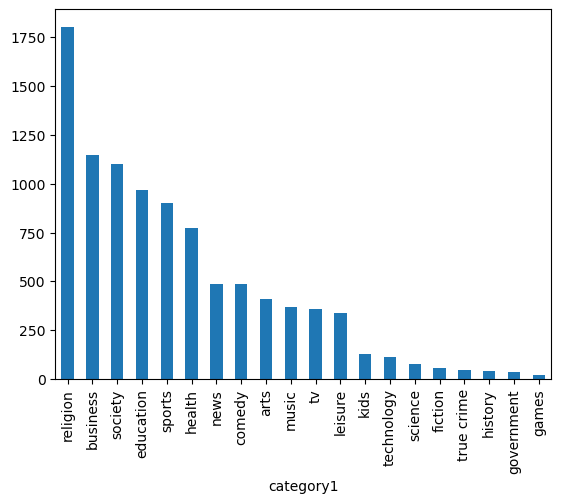

In [333]:
import matplotlib.pyplot as plt

episode_enriched['category1'].value_counts().plot(kind='bar')
plt.show()


**Average speaking time per episode:**

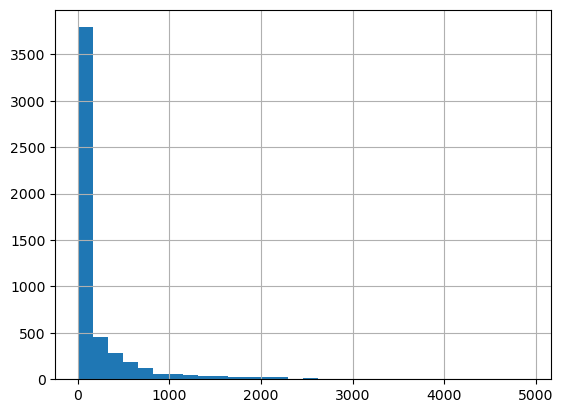

In [336]:
episode_enriched['avgTurnDuration'].hist(bins=30)
plt.show()


**Average Turn Duration:**

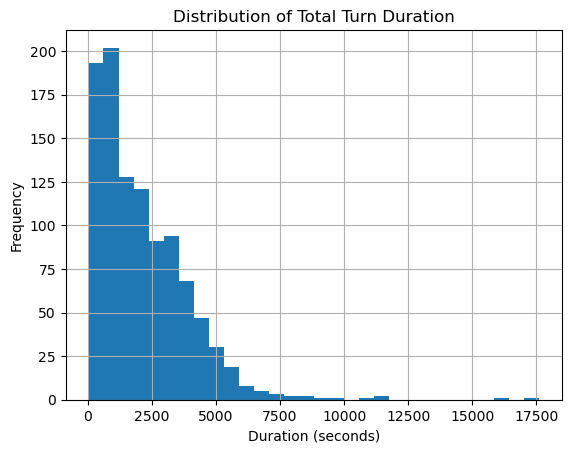

In [339]:
episode_enriched['totalTurnDuration'].hist(bins=30)
plt.title("Distribution of Total Turn Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


**Average Turn Duration vs. Number of Speaker Turns:**

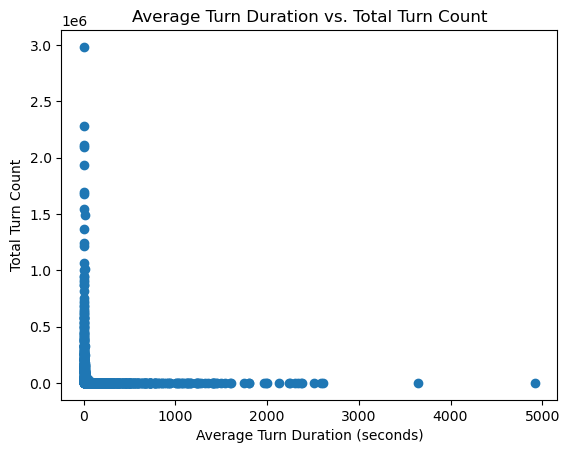

In [342]:
plt.scatter(episode_enriched['avgTurnDuration'], episode_enriched['totalTurnCount'])
plt.title("Average Turn Duration vs. Total Turn Count")
plt.xlabel("Average Turn Duration (seconds)")
plt.ylabel("Total Turn Count")
plt.show()


#### Interpretation

**Overall Trend:** There seems to be a general trend of decreasing Total Turn Count as Average Turn Duration increases. This suggests that episodes with longer average speaking turns tend to have fewer instances where the speaker changes.

**Clustering:** The data points are clustered towards the left side of the plot, indicating that a majority of episodes have a relatively low Average Turn Duration and a high Total Turn Count. This could mean that many podcasts have a conversational style with frequent speaker changes and shorter turns.

**Outliers:** There are a few outliers towards the right side of the plot with high Average Turn Duration and low Total Turn Count. These episodes likely feature longer, uninterrupted speaking segments, perhaps interviews or monologues.

**Role Diversity Across Episode**

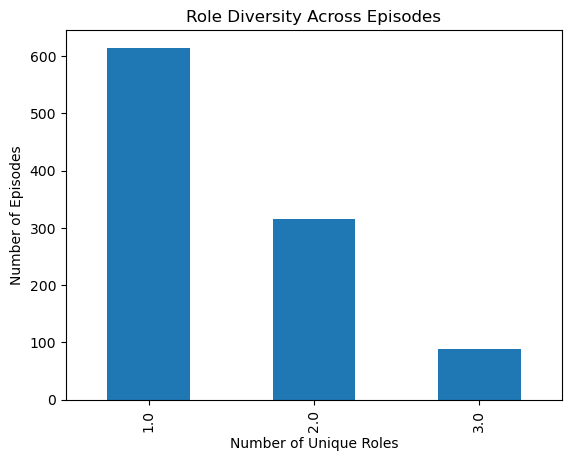

In [346]:
episode_enriched['uniqueRoles'].value_counts().plot(kind='bar')
plt.title("Role Diversity Across Episodes")
plt.xlabel("Number of Unique Roles")
plt.ylabel("Number of Episodes")
plt.show()


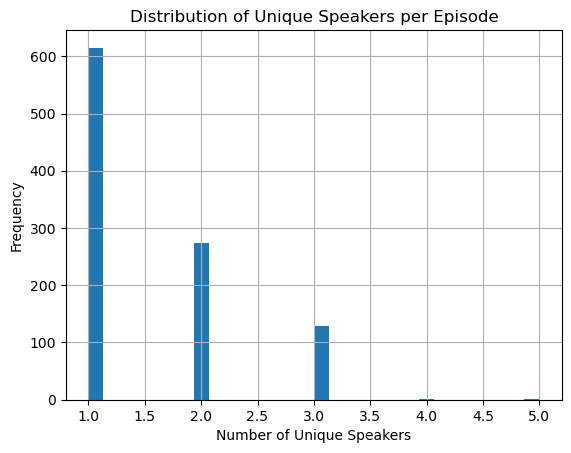

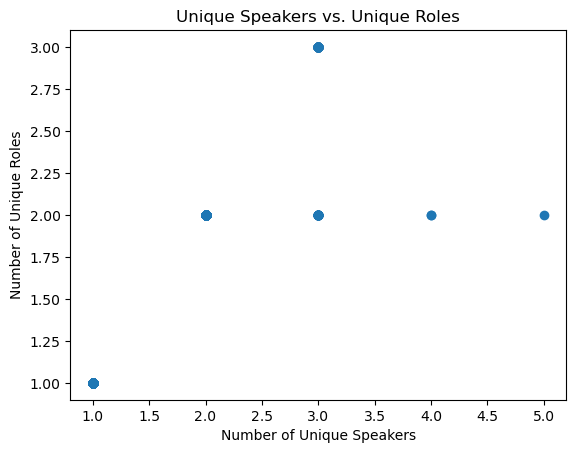

In [348]:
# Distribution of unique speakers
episode_enriched['uniqueSpeakers'].hist(bins=30)
plt.title("Distribution of Unique Speakers per Episode")
plt.xlabel("Number of Unique Speakers")
plt.ylabel("Frequency")
plt.show()

# Relationship between unique speakers and roles
plt.scatter(episode_enriched['uniqueSpeakers'], episode_enriched['uniqueRoles'])
plt.title("Unique Speakers vs. Unique Roles")
plt.xlabel("Number of Unique Speakers")
plt.ylabel("Number of Unique Roles")
plt.show()


**Distribution of Episode Duration**

Analyze the overall distribution of episode durations (durationSeconds) and identify potential outliers.

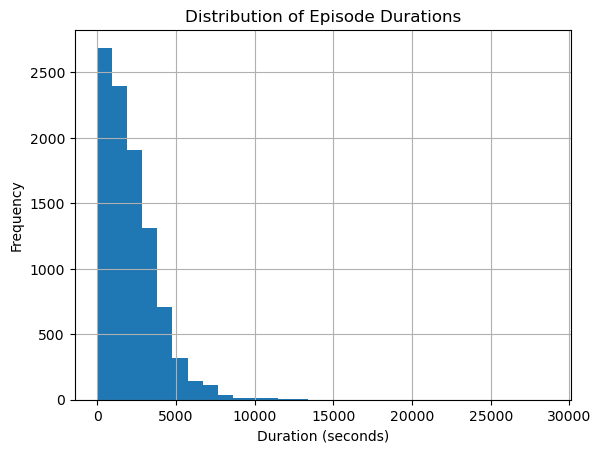

Outlier Episodes:
                                                epTitle  durationSeconds
15                              Ep 49 - Defund Politics           9988.0
16    Ep 48 - The Negro: A Proclamation to the World...           9263.0
41             Lucid Drinking - Episode 21 - Jake Mulka           8061.0
149   DnB Ep 270: Space Force Launches and Bombshell...           9801.0
314                                   RamCast Episode 5           7986.0
...                                                 ...              ...
9448              #303 Singer/Songwriter Danny Smith...           7908.0
9449         #300 'Three:33'... Tony, Eric and Danny...          10278.0
9452  #296 Nathan Olivarez from 'Stupid Drama' and '...           8136.0
9524                              Ep. 118 Protect Yours           8625.0
9558                           The end of the Anybodies           7935.0

[97 rows x 2 columns]


In [351]:
# Distribution of episode durations
episode_enriched['durationSeconds'].hist(bins=30)
plt.title("Distribution of Episode Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

# Identify outliers
outliers = episode_enriched[episode_enriched['durationSeconds'] > episode_enriched['durationSeconds'].quantile(0.99)]
print("Outlier Episodes:")
print(outliers[['epTitle', 'durationSeconds']])


**Category Analysis**

Explore the podcast categories (`category1`, `category2`, etc.) to understand the distribution and diversity.

Top Podcast Categories:
category1
religion     1802
business     1147
society      1101
education     968
sports        901
health        773
news          487
comedy        486
arts          410
music         367
Name: count, dtype: int64


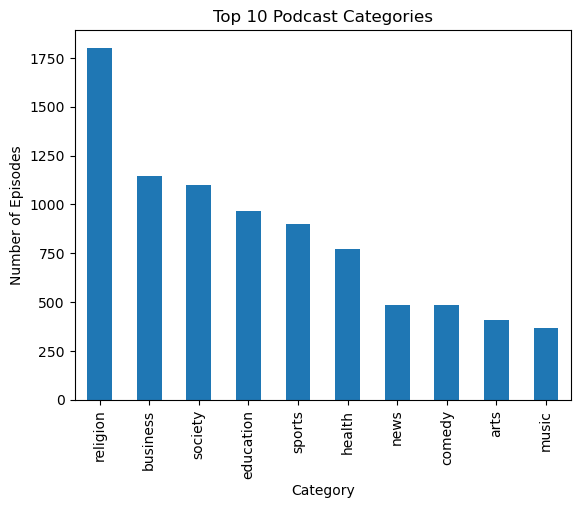

In [354]:
# Top categories
category_counts = episode_enriched['category1'].value_counts()
print("Top Podcast Categories:")
print(category_counts.head(10))

# Plot top 10 categories
category_counts.head(10).plot(kind='bar')
plt.title("Top 10 Podcast Categories")
plt.xlabel("Category")
plt.ylabel("Number of Episodes")
plt.show()


**Role-Based Duration Analysis**

Analyze how much time each inferred role (host, guest, etc.) typically speaks during episodes. 

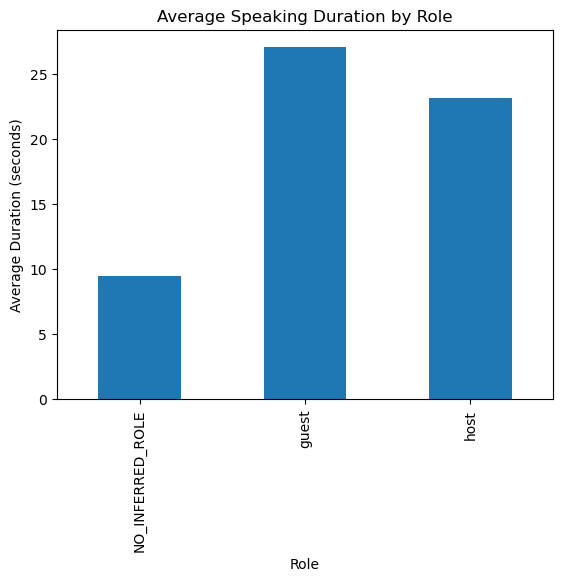

In [357]:
# Calculate average speaking duration per role
role_durations = speaker_turn_data.groupby('inferredSpeakerRole').agg({
    'duration': 'mean'
}).reset_index()

# Plot average speaking duration by role
role_durations.plot(x='inferredSpeakerRole', y='duration', kind='bar', legend=False)
plt.title("Average Speaking Duration by Role")
plt.xlabel("Role")
plt.ylabel("Average Duration (seconds)")
plt.show()


### b. Episode Level Further Analysis ###

**I. Combine All Category Columns**

* Extract all categories from `category1` to `category8`.
* Flatten them into a single list to analyze overall category frequency.

In [360]:
# Combine all category columns into one DataFrame
category_columns = ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8']
all_categories = episode_enriched[category_columns].melt(value_name='category')['category'].dropna()

# Count category occurrences
category_counts = all_categories.value_counts()
print("Top Categories Across All Levels:")
print(category_counts.head(10))


Top Categories Across All Levels:
category
religion        1928
spirituality    1925
culture         1586
society         1586
business        1476
education       1467
christianity    1073
health          1027
fitness          993
sports           971
Name: count, dtype: int64


**II. Multi-Bar Plot for Each Category Level:**

* Create separate bar plots for each category column (`category1`, `category2`, ..., `category8`) to visualize how frequently categories appear at each level.


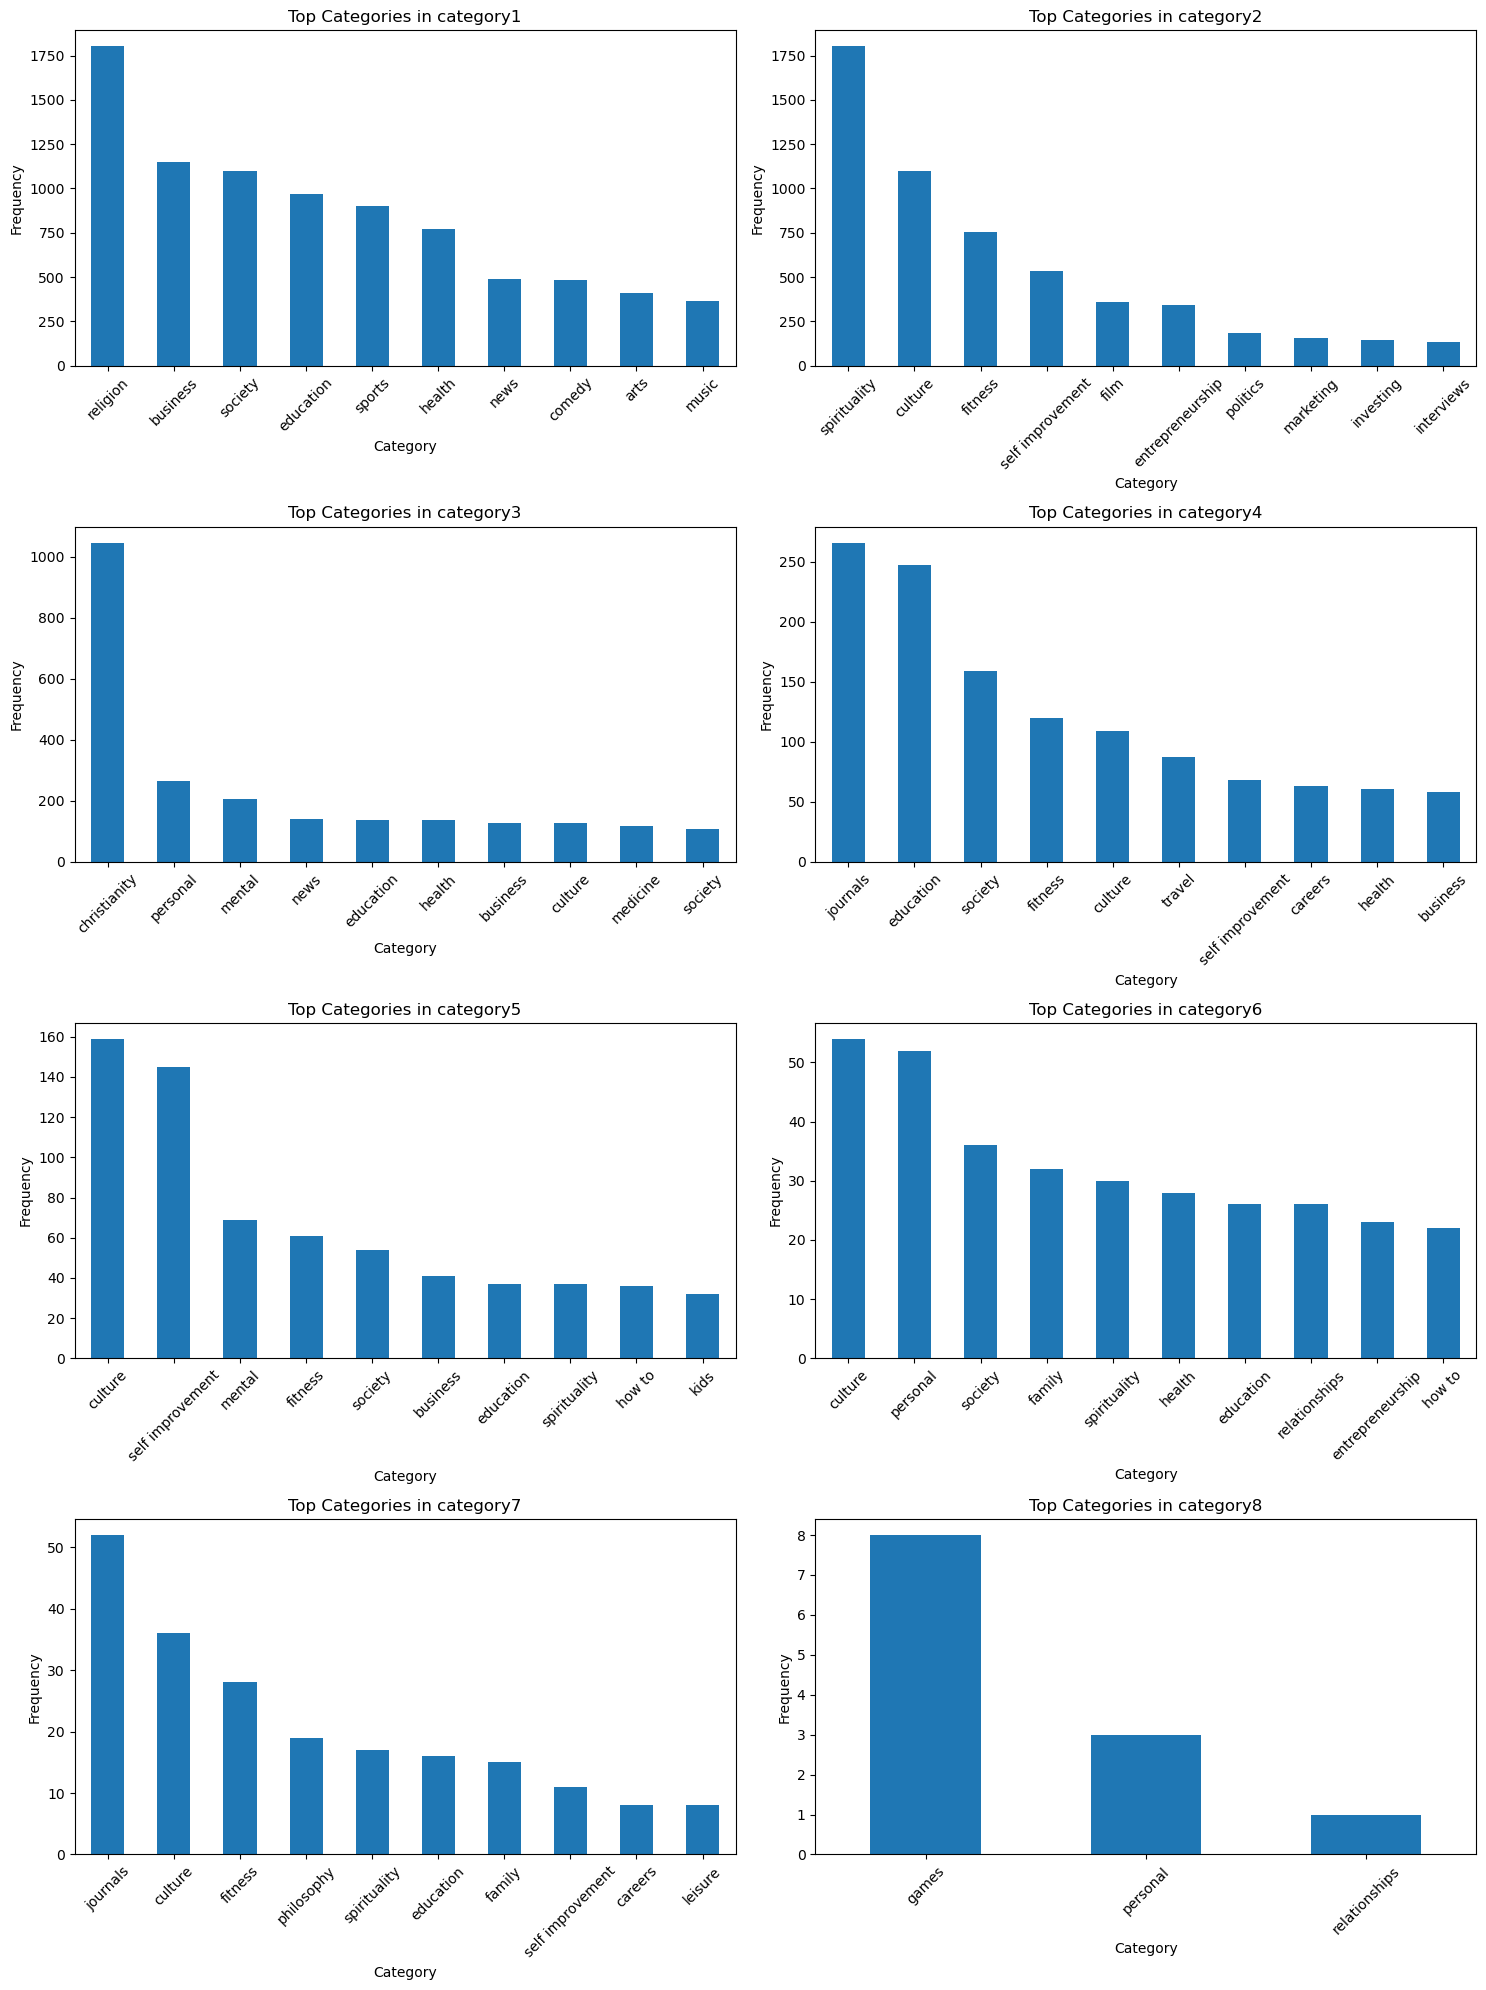

In [363]:
import matplotlib.pyplot as plt

# Plot each category column's distribution
fig, axs = plt.subplots(4, 2, figsize=(15, 20))  # Create subplots for 8 category columns
axs = axs.flatten()

for idx, col in enumerate(category_columns):
    episode_enriched[col].value_counts().head(10).plot(kind='bar', ax=axs[idx])
    axs[idx].set_title(f"Top Categories in {col}")
    axs[idx].set_xlabel("Category")
    axs[idx].set_ylabel("Frequency")
    axs[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**II. Showcase Combined Category Distribution:**

* Combine all category columns into one to showcase the top categories across all levels.



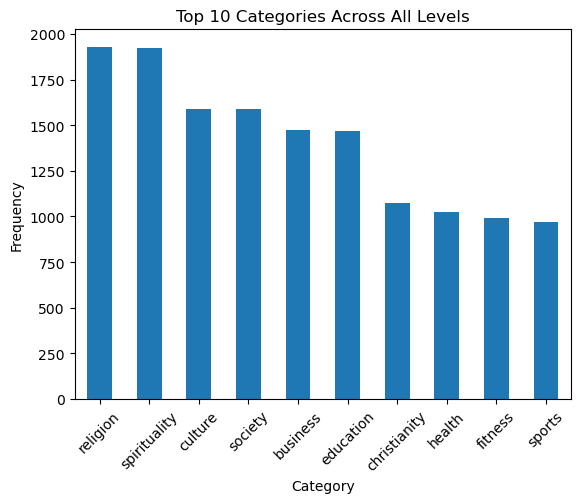

In [366]:
# Plot combined category distribution
category_counts.head(10).plot(kind='bar')
plt.title("Top 10 Categories Across All Levels")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


## Why Use Latent Dirichlet Allocation (LDA)?

Latent Dirichlet Allocation (LDA) is a powerful technique for our analysis due to its ability to:

* **Uncover Hidden Themes:** Podcasts often revolve around themes or topics that aren't always explicitly labeled in the metadata. LDA excels at identifying these latent topics within the text data.
* **Handle Unstructured Text:** LDA is well-suited for analyzing large, unstructured text data like podcast transcripts, provided they have been cleaned and preprocessed.
* **Align with Our Goals:** Given our aim to identify latent topics within the podcast transcripts, LDA presents a logical next step in our analysis.

LDA will enable us to gain deeper insights into the content and identify patterns, categories, or speaker behavior that may not be readily apparent.

### Steps to Apply LDA

Here's a general workflow to implement LDA on the podcast transcripts:

   * **Clean the Text:** Remove punctuation, numbers, and stopwords.
   * **Lowercase the Text:** Convert all text to lowercase for consistency.
   * **Tokenize:** Split the text into individual words (tokens).
   * **Lemmatize:** Reduce words to their base or root form (e.g., "running" to "run").

### 1. Data Prepration

Here's a general workflow to implement LDA on the podcast transcripts:

**A. Stopword Removal and Custom Tokenizer, and Text Cleaning**

* Used *SpaCy* to tokenize the text and excluded stopwords using NLTK's English stopword list.
* Focused on alphabetic tokens and skipped non-alphabetic tokens (like numbers, punctuation)
* Preprocessed the transcript column (from `episode_data`) and created a new column `cleaned_transcript` for the cleaned text.

In [371]:
# Ensure stopwords and Spacy are set up
# import nltk
# import spacy
# nltk.download("stopwords")
stop_words_en = nltk.corpus.stopwords.words("english")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])

# Define a custom tokenizer
def custom_tokenizer(text):
    tokenized_text = nlp(text)
    return [tok.text for tok in tokenized_text if tok.is_alpha and tok.text.lower() not in stop_words_en]

# Preprocessing the text
episode_data['cleaned_transcript'] = episode_data['transcript'].apply(
    lambda x: ' '.join(custom_tokenizer(x)) if pd.notnull(x) else ''
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**B. Bag-of-Words (BoW) Matrix:**

* Used Scikit-learn's *CountVectorizer* to create the **BoW matrix**
* Applied frequency thresholds with max_df (ignore terms in 90%+ documents) and min_df (keep terms in 20%+ documents).


In [373]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the BoW matrix
bow_vectorizer = CountVectorizer(
    analyzer="word",
    tokenizer=custom_tokenizer,
    lowercase=True,
    stop_words=stop_words_en,
    max_df=0.90,
    min_df=0.2  # Adjust thresholds for term frequency
)
bow_matrix = bow_vectorizer.fit_transform(episode_data['cleaned_transcript'])

# Check the shape of the BoW matrix
print(f"BoW Matrix Shape: {bow_matrix.shape}")


BoW Matrix Shape: (10000, 865)


###  2. Choose LDA Parameter and Train the LDA Model

**C. Latent Dirichlet Allocation (LDA):**

* Fitted the LDA model with 10 topics (`n_components=10`).
* Created a document-topic matrix where each row corresponds to an episode and each column indicates the proportion of that episode's content belonging to a topic.



In [376]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA to the BoW matrix
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust n_components for more topics
document_topic_matrix = lda.fit_transform(bow_matrix)

# Format the document-topic matrix
document_topic_matrix = pd.DataFrame(
    document_topic_matrix,
    columns=[f"topic_{i}" for i in range(lda.n_components)],
    index=episode_data.index
)

# Check the document-topic matrix
print(document_topic_matrix.head())


    topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0  0.003334  0.003334  0.003334  0.003334  0.003334  0.077897  0.237011   
1  0.003705  0.003705  0.003705  0.003705  0.003705  0.003705  0.174773   
2  0.000403  0.000403  0.000403  0.238466  0.000403  0.000403  0.000403   
3  0.194226  0.000556  0.000556  0.000556  0.101320  0.000556  0.000556   
4  0.000521  0.000521  0.225225  0.000521  0.000521  0.000521  0.000521   

    topic_7   topic_8   topic_9  
0  0.661753  0.003334  0.003334  
1  0.795588  0.003705  0.003705  
2  0.758307  0.000403  0.000403  
3  0.700564  0.000556  0.000556  
4  0.462002  0.309126  0.000521  


### 3. Analyze the Result

**D. Extract Term-Topic Matrix(LDA):**

* Format the term-topic matrix to inspect the relationship between words and topics.


In [379]:
# Extract term-topic matrix
term_topic_matrix = lda.components_.T
term_topic_matrix = term_topic_matrix / term_topic_matrix.sum(axis=1, keepdims=True)  # Normalize
term_topic_matrix = pd.DataFrame(
    term_topic_matrix,
    columns=[f"topic_{i}" for i in range(lda.n_components)],
    index=bow_vectorizer.get_feature_names_out()
)

# Inspect the term-topic matrix
print(term_topic_matrix.head())


             topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
ability     0.120987  0.065388  0.017819  0.087166  0.021644  0.105506   
able        0.195215  0.116459  0.051933  0.053095  0.022993  0.061491   
absolutely  0.120603  0.088023  0.135017  0.078883  0.097400  0.011574   
access      0.284706  0.032679  0.037954  0.011103  0.009590  0.042655   
across      0.077103  0.043350  0.059627  0.037254  0.052233  0.028545   

             topic_6   topic_7   topic_8   topic_9  
ability     0.015734  0.213694  0.334883  0.017178  
able        0.060901  0.126068  0.280324  0.031521  
absolutely  0.031781  0.106830  0.263298  0.066589  
access      0.040010  0.112936  0.412295  0.016072  
across      0.161468  0.046874  0.430619  0.062927  


**E. Assign Topics to Documents**

* Use the document-topic matrix to assign a dominant topic to each document.


In [382]:
# Assign the dominant topic to each document
episode_data['dominant_topic'] = document_topic_matrix.idxmax(axis=1)

# Inspect the assigned topics
print(episode_data[['epTitle', 'dominant_topic']].head())


                         epTitle dominant_topic
0  Best of SingOut SpeakOut No.3        topic_7
1                  It's All Gone        topic_7
2             Today Is Yesterday        topic_7
3                  Saturn Return        topic_7
4             Quarterlife Crisis        topic_7


**E. Inspect Top Words for Each Topic**

* Extract and display the top words for each topic.


In [562]:
# Function to get top words for each topic
def top_words_per_topic(term_topic_matrix, n_top_words=10):
    top_words = {}
    for topic in term_topic_matrix.columns:
        top_words[topic] = term_topic_matrix[topic].nlargest(n_top_words).index.tolist()
    return pd.DataFrame(top_words)

# Get top words for each topic
top_words = top_words_per_topic(term_topic_matrix, n_top_words=10)
print(top_words)

# Save the top words to a CSV file
top_words.to_csv("top_words.csv") 


    topic_0   topic_1 topic_2 topic_3   topic_4 topic_5  topic_6   topic_7  \
0  business        um    yeah   games     movie   jesus      dad      self   
1   company        uh     yep    game      star    lord    lived    energy   
2   content      kids    cool  season   watched  church   mother     brain   
3      sell   parents  record     win  episodes  spirit    moved    upbeat   
4     value    school      oh    team  favorite     god    house   connect   
5     email   college   weird  played    series    holy     road   journey   
6   website     class     fun    play        tv  father     town   feeling   
7     money  training  sounds     gon     liked    word   street      body   
8     build      felt    nice      na     shows   earth     door   sharing   
9       buy     teach   sound    beat       fan    says  brother  powerful   

      topic_8 topic_9  
0      states   black  
1   certainly    shit  
2      public   white  
3       terms  saying  
4    research    girl

**F. Manually label topics based on the top words observed**

In [388]:
topic_labels = {
    'topic_0': 'Business',
    'topic_1': 'Education/Family',
    'topic_2': 'Casual',
    'topic_3': 'Sports/Gaming',
    'topic_4': 'Entertainment',
    'topic_5': 'Christianity',
    'topic_6': 'Family/home',
    'topic_7': 'Personal Development',
    'topic_8': 'Public',
    'topic_9': 'Social/Slangs'
}


#### Visualize Topics:

**Step 1. Bar Plots for Topic Distribution**

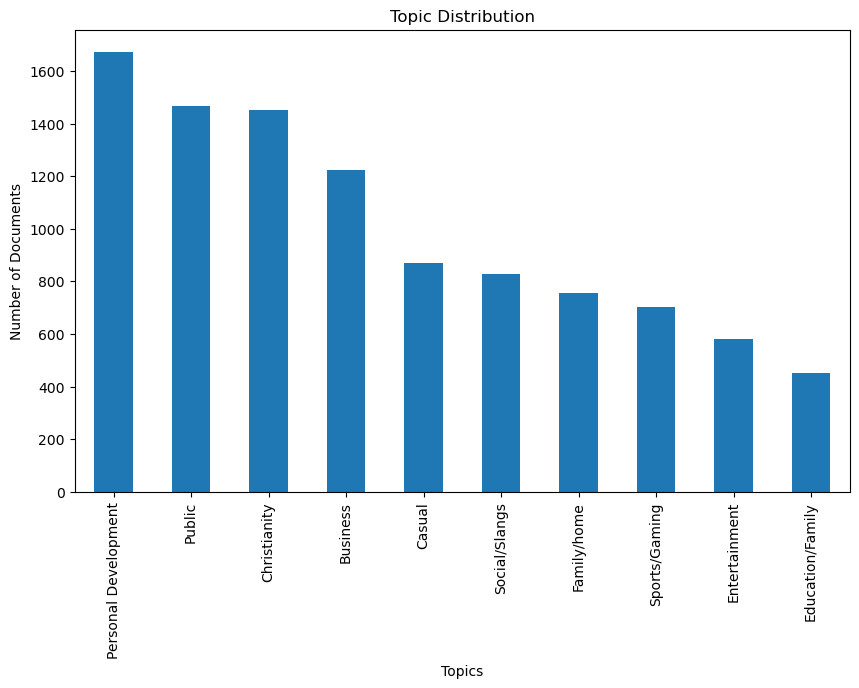

In [392]:
import seaborn as sns
import matplotlib.pyplot as plt

# To use the default style which has a white background
plt.style.use('default')
# Apply labels to the DataFrame for easier interpretation
episode_data['dominant_topic_label'] = episode_data['dominant_topic'].map(topic_labels)

# Bar plot for topic distribution with labeled topics
topic_counts = episode_data['dominant_topic_label'].value_counts()
topic_counts.plot(kind='bar', figsize=(10, 6), title="Topic Distribution")
plt.xlabel("Topics")
plt.ylabel("Number of Documents")
plt.show()




**Step 2: Consolidate Categories**

Create a cross-tabulation to see the frequency of each topic label appearing with specific categories.

In [395]:
category_columns = ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8']

# Combine categories into a single string column
episode_data['combined_categories'] = episode_data[category_columns].apply(
    lambda row: ', '.join(row.dropna()), axis=1
)


**Step 3. Cross-Tabulate Topics and Categories**

Create a cross-tabulation to see the frequency of each topic label appearing with specific categories.

In [398]:
topic_category_crosstab = pd.crosstab(
    episode_data['category1'],
    episode_data['dominant_topic_label']
)
topic_category_crosstab.head()


dominant_topic_label  Business  Casual  Christianity  Education/Family  \
category1                                                                
arts                        58      51             7                34   
business                   655      13             4                32   
comedy                      10     116             5                11   
education                  154      40            26                60   
fiction                      1       4             2                 1   

dominant_topic_label  Entertainment  Family/home  Personal Development  \
category1                                                                
arts                             62           34                    45   
business                          5           50                   183   
comedy                           57           49                    30   
education                        10           72                   421   
fiction                           3           25                    12   

dominant_topic_label  Public  Social/Slangs  Sports/Gaming  
category1                                                   
arts                      74             35             11  
business                 173             27             11  
comedy                    10            177             25  
education                109             73             12  
fiction                    0              7              3

**Step 4: Combine Metadata with Topics**

* Combine metadata categories (`category1`) with LDA topics to create enriched labels:


In [401]:
episode_data['final_label'] = episode_data.apply(
    lambda x: f"{x['category1']} - {x['dominant_topic_label']}", axis=1
)
print(episode_data['final_label'].value_counts())

final_label
religion - Christianity             1355
business - Business                  655
sports - Sports/Gaming               471
education - Personal Development     421
health - Personal Development        296
                                    ... 
government - Casual                    1
technology - Family/home               1
fiction - Education/Family             1
fiction - Business                     1
kids - Sports/Gaming                   1
Name: count, Length: 178, dtype: int64


**Step 5: Visualize the Relationship**

Use a heatmap to visualize the alignment between topic labels and categories.

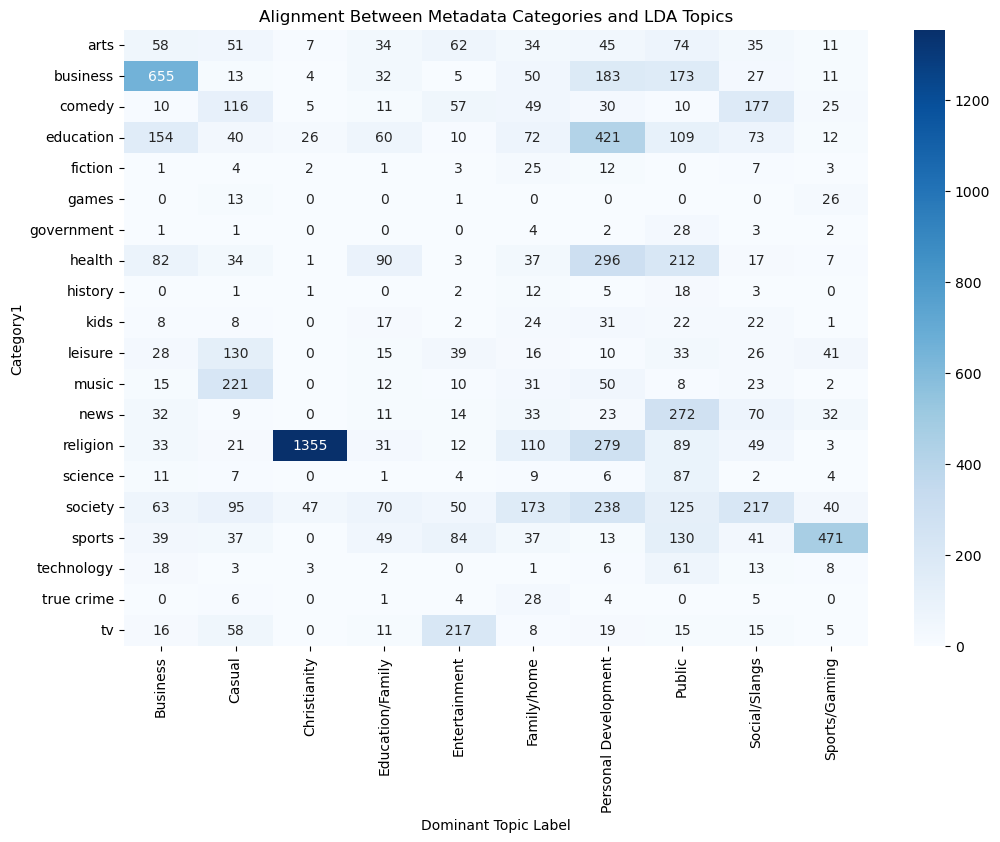

In [404]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(topic_category_crosstab, annot=True, fmt="d", cmap="Blues")
plt.title("Alignment Between Metadata Categories and LDA Topics")
plt.xlabel("Dominant Topic Label")
plt.ylabel("Category1")
plt.show()


**Step 6: Perform UMAP Visualization**

* Visualize the BERTopic clusters in low-dimensional space using UMAP:

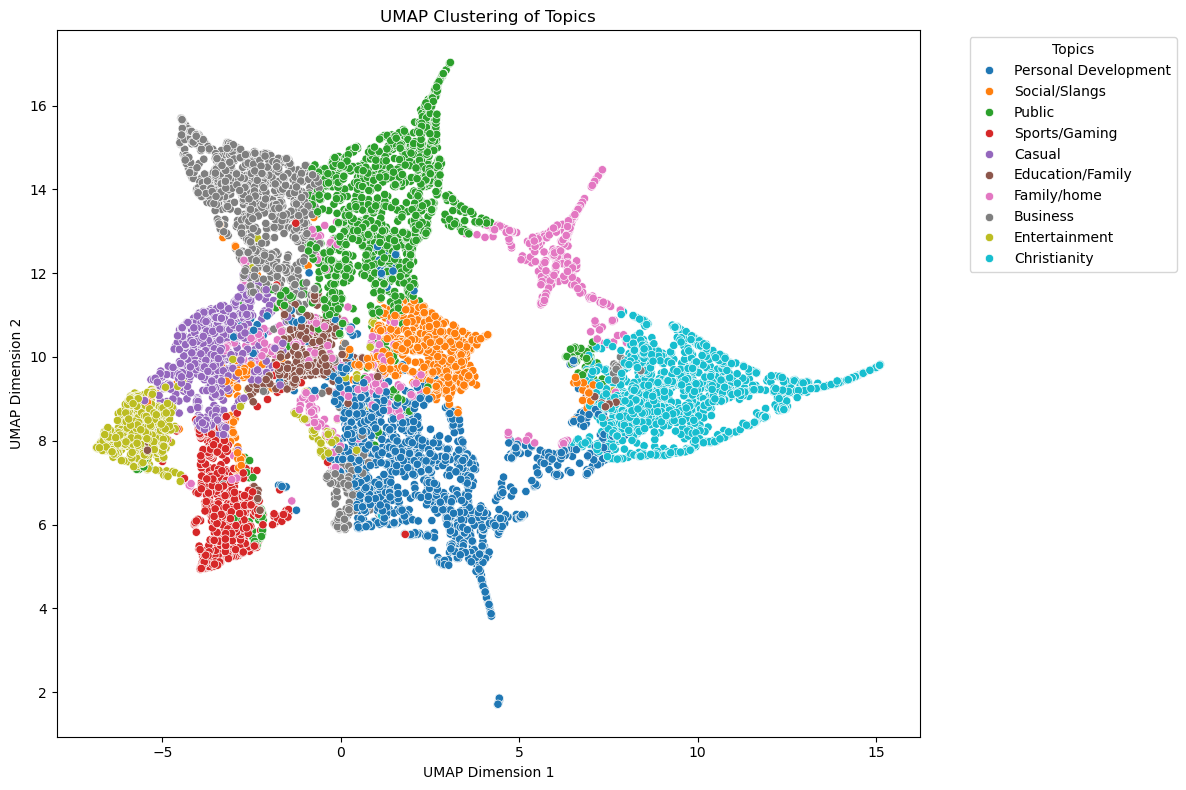

In [407]:
# UMAP visualization
import umap
import umap.umap_ as umap 
import matplotlib.pyplot as plt
import seaborn as sns

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(document_topic_matrix)

# Add UMAP coordinates to DataFrame
episode_data['umap_x'] = umap_embeddings[:, 0]
episode_data['umap_y'] = umap_embeddings[:, 1]

# Manually label topics (assuming this was done before)
# topic_labels = {...}
# episode_data['dominant_topic_label'] = episode_data['dominant_topic'].map(topic_labels)

# Scatterplot for UMAP visualization with labeled topics
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='dominant_topic_label',  # Use the labeled topics for color coding
    data=episode_data,
    palette='tab10'  # Using husl color palette for diverse, distinguishable colors
)
plt.title("UMAP Clustering of Topics")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside plot to avoid overlap
plt.tight_layout()
plt.show()

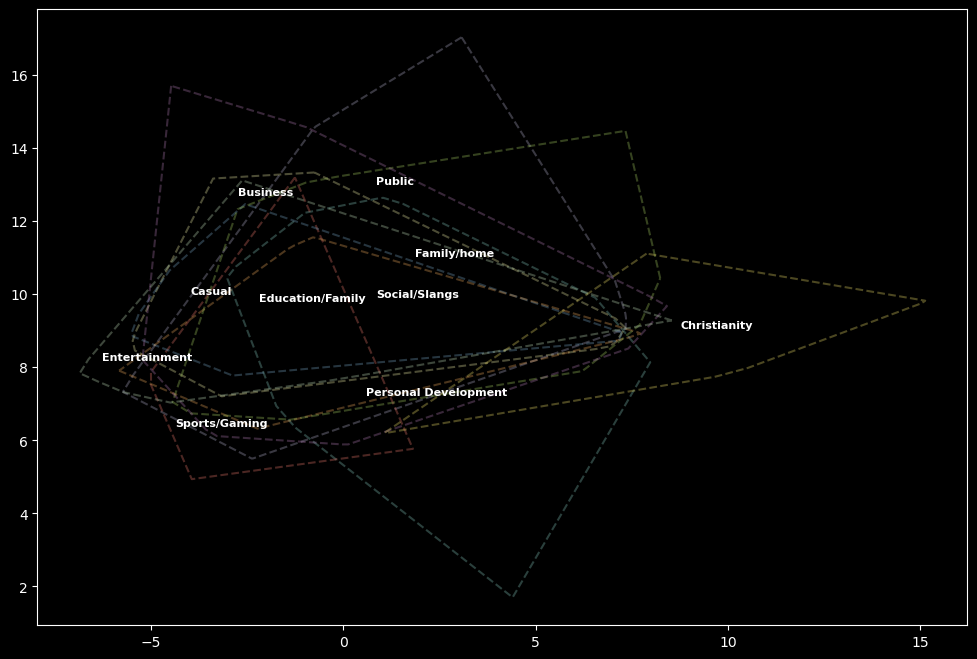

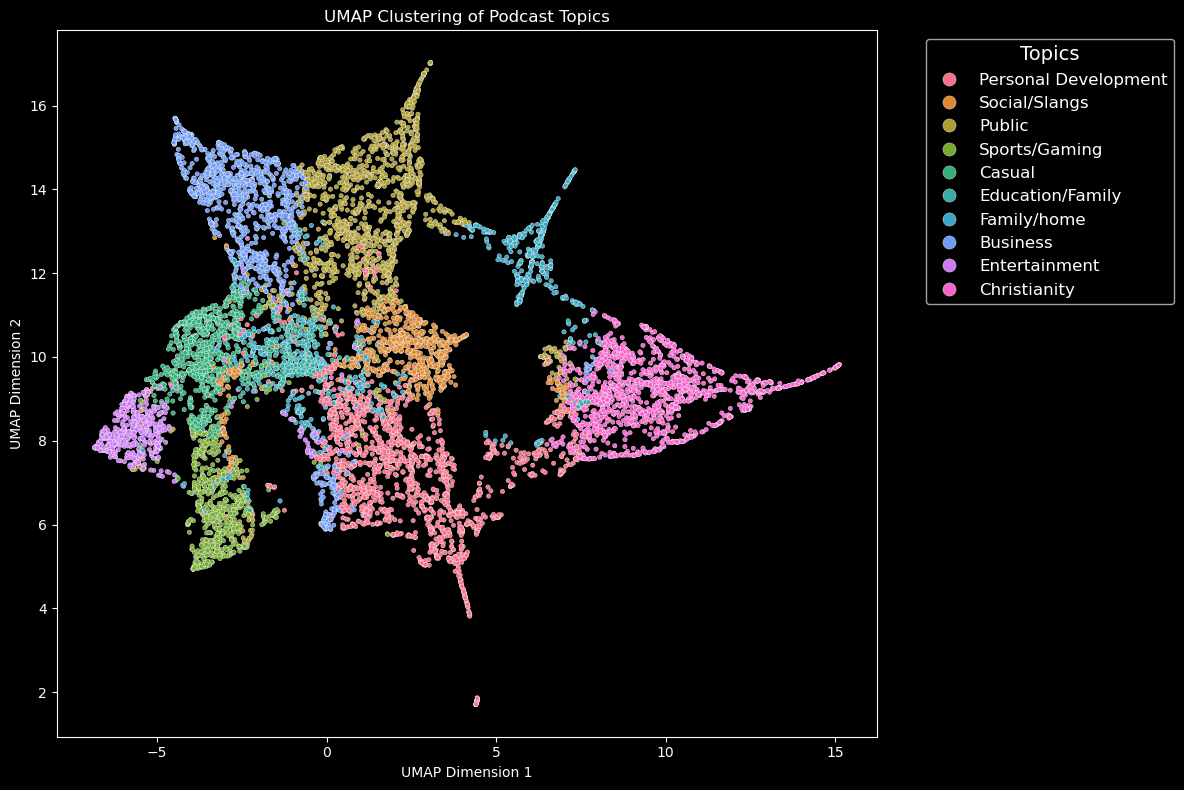

In [409]:
# UMAP visualization More Better Visual
import umap
import umap.umap_ as umap 
import matplotlib.pyplot as plt
import seaborn as sns

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(document_topic_matrix)

from scipy.spatial import ConvexHull

# Calculate centroids of clusters
centroids = episode_data.groupby('dominant_topic_label')[['umap_x', 'umap_y']].mean()

# Use Large Background
plt.style.use('dark_background')

plt.figure(figsize=(12, 8))  # Larger size for more room

for label, (x, y) in centroids.iterrows():
    plt.text(
        x, y, label, fontsize=8, ha='center',
        weight='bold', va='center', color='white'
    )

for label in episode_data['dominant_topic_label'].unique():
    points = episode_data[episode_data['dominant_topic_label'] == label][['umap_x', 'umap_y']].values
    if len(points) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the hull
        plt.plot(points[hull_points, 0], points[hull_points, 1], alpha=0.3, linestyle='--')


# Add UMAP coordinates to DataFrame
episode_data['umap_x'] = umap_embeddings[:, 0]
episode_data['umap_y'] = umap_embeddings[:, 1]

# Scatterplot for UMAP visualization with labeled topics
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='dominant_topic_label',  # Use the labeled topics for color coding
    data=episode_data,
    s=10,
    alpha=1,
    palette='husl'  # Using husl color palette for diverse, distinguishable colors
)
plt.title("UMAP Clustering of Podcast Topics")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
# Adjust the legend
legend = plt.legend(
    title="Topics",
    bbox_to_anchor=(1.05, 1),  # Place legend outside the plot
    loc='upper left',
    fontsize=12,  # Font size for legend text
    title_fontsize=14,  # Font size for legend title
    markerscale=3.0  # Increase marker size in the legend
)
plt.tight_layout()
plt.show()

#### Measure Agreement

To statistically measure the alignment between topic labels and categories, compute the mutual information score or Cohen's kappa.

**Step 1: Compute Mutual Information**

This measures how much information the categories provide about the topic labels.

In [412]:
# Replace missing values with a placeholder
episode_data['dominant_topic_label'] = episode_data['dominant_topic_label'].fillna("Unknown")
episode_data['category1'] = episode_data['category1'].fillna("Unknown")

# Compute mutual information score
from sklearn.metrics import mutual_info_score
mutual_info = mutual_info_score(episode_data['dominant_topic_label'], episode_data['category1'])
print(f"Mutual Information Score (using category1): {mutual_info:.2f}")


Mutual Information Score (using category1): 0.64


**Step 2: Compute Cohen's Kappa**

This measures agreement between the categories and topic labels.

In [416]:
from sklearn.metrics import cohen_kappa_score

# Encode topic labels and categories numerically
from sklearn.preprocessing import LabelEncoder
le_topics = LabelEncoder()
le_categories = LabelEncoder()

topics_encoded = le_topics.fit_transform(episode_data['category1'])
categories_encoded = le_categories.fit_transform(episode_data['category1'])

# Compute Cohen's Kappa
kappa = cohen_kappa_score(topics_encoded, categories_encoded)
print(f"Cohen's Kappa: {kappa:.2f}")


Cohen's Kappa: 1.00


#### What the Results Indicate

**Mutual Information Score (0.64):** 

This indicates a moderate-to-strong dependency between `dominant_topic_label` and `category1`. While not perfect, it suggests that `category1` captures meaningful information about the topic labels.

**Cohen's Kappa (1.00):**

A perfect Kappa score of 1.00 suggests complete agreement between `dominant_topic_label` and `category1`. This is a very strong indicator that `category1` aligns perfectly with the dominant topics.

#### Why It Works with `category1`

* **Primary Labeling:** `category1` represents the most significant or primary label, making it more likely to align with the dominant topics. 

* **Reduced Noise and Complexity:** Combining multiple categories (e.g., `combined_category`) can dilute the alignment due to overlaps or conflicting information across categories. For example, combining `category2` and `category3` can introduce noise and complexity, potentially leading to unexpected results like a high Mutual Information Score (e.g., 1.03) and a low Cohen's Kappa (e.g., 0.00), which is an unusual combination.

By focusing on `category1`, we avoid the noise and complexity introduced by secondary and tertiary labels, leading to a clearer and more meaningful relationship with the dominant topics.

## BERTopic: Leveraging Transformer Models

Here, we are using Transformer-based models like BERTopic to improve upon LDA for more nuanced, context-aware, and semantically rich topic extractions. Unlike LDA, which relies on a bag-of-words approach, BERTopic leverages contextual embeddings (e.g., BERT, RoBERTa) to generate topics that are better aligned with the underlying semantics of the text.

**Why Use BERTopic?**

* **Context-Aware:** BERTopic uses sentence embeddings from transformer models, enabling it to capture the context and semantics of phrases rather than just word frequency. For example, "climate change" and "global warming" would be grouped under the same topic, even though the words differ.

* **Dynamic Topic Granularity:** BERTopic can generate hierarchical topics, allowing you to explore high-level themes and drill down into subtopics.

* **Suitable for Short Texts:** While LDA struggles with short text (e.g., podcast episode titles or brief transcripts), BERTopic performs well.

* **Enhanced Visualizations:** BERTopic provides interactive visualizations like topic overviews, bar charts, and timelines, which facilitate a deeper understanding of the topics.

**Step 1: Generate Sentence Embeddings**

BERTopic requires sentence embeddings for documents. You can use a model like `all-MiniLM-L6-v2` from Sentence Transformers:

In [421]:
## Now for BERT Topic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


texts = episode_data['cleaned_transcript'].dropna().tolist()

print(f"Number of documents: {len(texts)}")
# Create embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(texts, show_progress_bar=True)


Number of documents: 10000


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

**Step 2: Apply BERTopic**

Use BERTopic to extract topics from the embeddings:

In [135]:
# Initialize BERTopic
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# Fit the model
topics, probs = topic_model.fit_transform(texts, embeddings)


2024-12-29 10:47:51,601 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-29 10:47:55,677 - BERTopic - Dimensionality - Completed ✓
2024-12-29 10:47:55,678 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-29 10:48:00,985 - BERTopic - Cluster - Completed ✓
2024-12-29 10:48:00,987 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-29 10:48:07,290 - BERTopic - Representation - Completed ✓


**Step 3: Refined Topic Model to Tailor BERTopic Model (Recommended)**

Here using number of hyperparameters optimization, we have tailored the BERTopic model to our specific needs by incorporating a customized UMAP step. This customization involves adjusting hyperparameters such as `n_neighbors`, `min_dist`, and `n_components` within the UMAP model. This step was recommended because in Step 2, we observed relatively low coherence scores. 

By adjusting these parameters, you can influence how the data is projected into a lower-dimensional space, which can significantly impact the quality and interpretability of the resulting topics.

**Note:** The optimal UMAP parameters will vary depending on the dataset and the desired outcome. Experimentation with different parameter values is often necessary to find the best configuration. For this specific implementation, I experimented with various parameter combinations and found the current configuration to be optimal for this particular dataset.

In [424]:
# Fine-Tuned topic Model

from umap import UMAP
from bertopic import BERTopic

# Create UMAP model with custom parameters
umap_model = UMAP(
    n_neighbors=15,  # More neighbors for more global structure, less for local
    n_components=10,  # Number of dimensions in the reduced space
    metric='cosine', # Distance metric ('euclidean', 'manhattan', etc.)
    random_state=42  # For reproducibility
)

# Create BERTopic model with the custom UMAP model
topic_model = BERTopic(umap_model=umap_model)

# Fit the model and transform the data
topics, probs = topic_model.fit_transform(texts, embeddings)

**Step 5: Extracted Topic Information:**

Retrieved the topic details (e.g., topic ID, word distribution, and document counts).

In [426]:
# Get topic information
topic_info = topic_model.get_topic_info()
print(topic_info)


     Topic  Count                                 Name  \
0       -1   5276              -1_like_yeah_know_think   
1        0    426          0_black_people_police_white   
2        1    181   1_business_sales_product_marketing   
3        2    150  2_students_school_teachers_learning   
4        3    142                3_fat_diet_weight_eat   
..     ...    ...                                  ...   
138    137     11            137_like_yeah_ginger_guys   
139    138     11              138_book_yes_books_show   
140    139     10      139_speech_english_non_speaking   
141    140     10          140_abortion_yeah_isis_guys   
142    141     10      141_caribbean_disney_resort_pop   

                                        Representation  \
0    [like, yeah, know, think, going, one, people, ...   
1    [black, people, police, white, know, trump, li...   
2    [business, sales, product, marketing, people, ...   
3    [students, school, teachers, learning, educati...   
4    [fat, di

### Visualize Topics 

* BERTopic Provides several built-in visualizations: 

**1: Interactive Exploration** 

* Use BERTopic's `visualize_barchart()` to explore term importance interactively

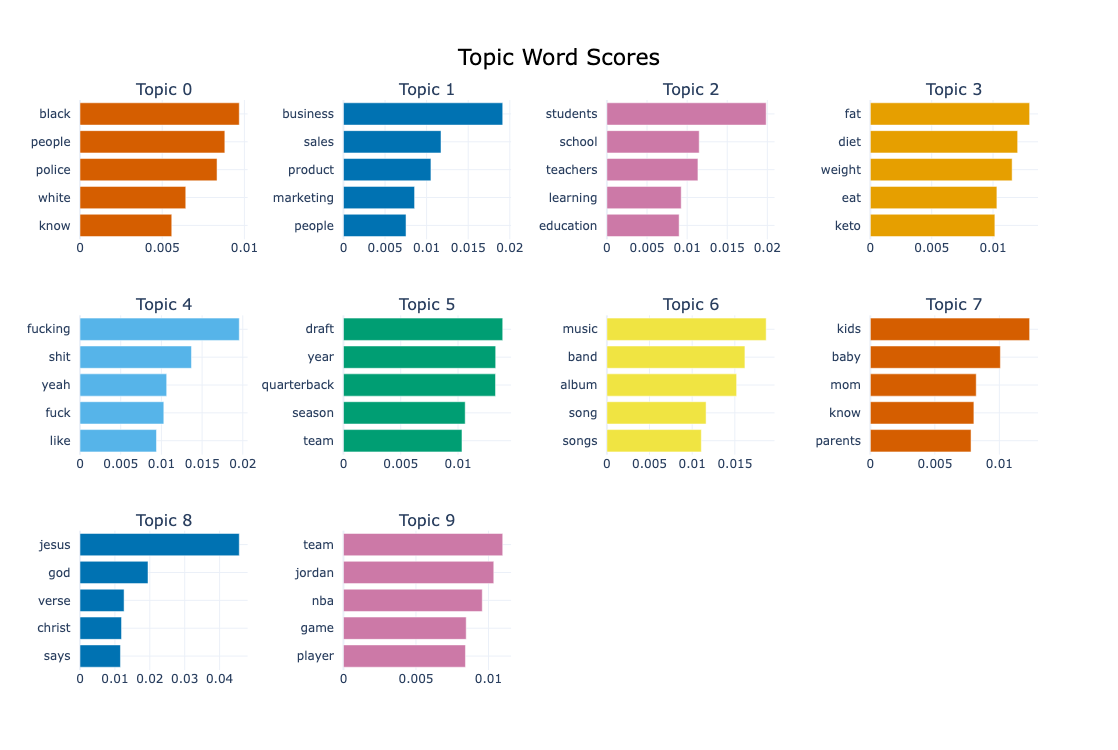

In [430]:
topic_model.visualize_barchart(top_n_topics=10)


**2: Visualize Topics** 

* We call `.visualize_topics` to create a 2D representation of your topics.

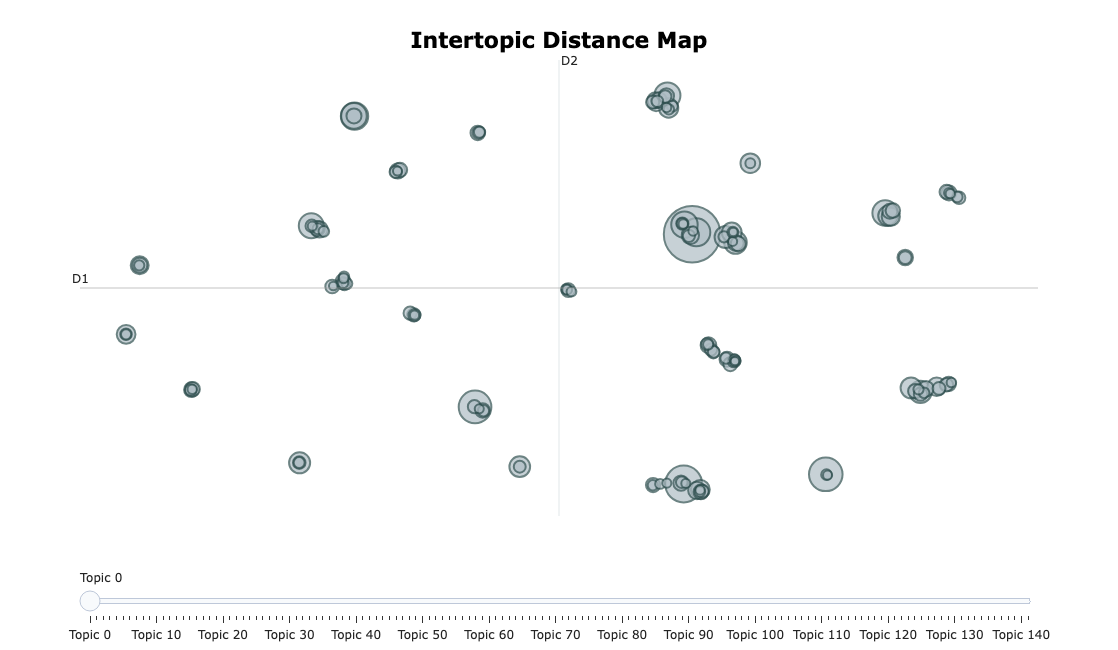

In [433]:
topic_model.visualize_topics()


In [435]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
fig = topic_model.visualize_documents(
    texts,
    reduced_embeddings=reduced_embeddings,
    topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    title="Documents and Topics using Visualize Documents (BERTopic)",
    hide_annotations=True,
    width=900,
    height=700
)
fig.write_html("document_topics.html")  # Save as HTML


**3: Visualize Topic Similarity** 

* We call `.visualize_heatmaps()` to create a a matrix indicating how similar cewrtain topics are to each other. To visualize the heatmap, we run the following. 

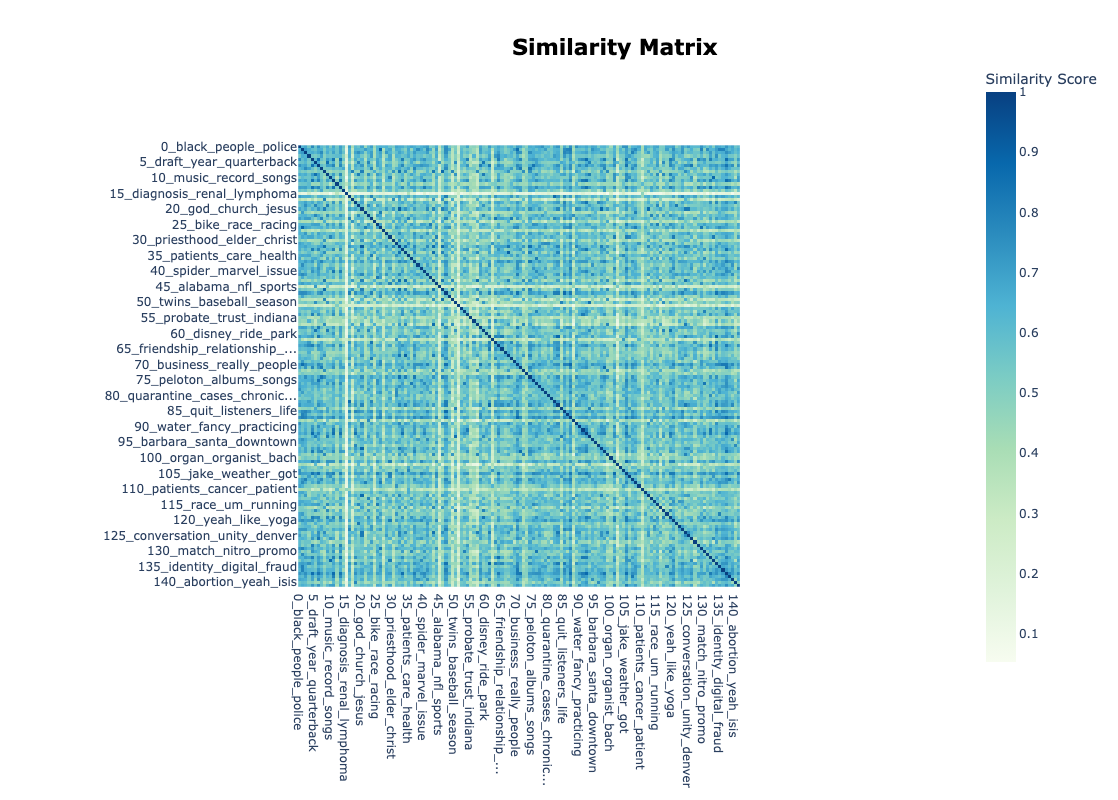

In [437]:
# Visualize topic similarity
topic_model.visualize_heatmap()


**4: Visualize Topics Over Time** 

After creating topics over time with Dynamic Topic Modeling, we can visualize these topics by leveraging the interactive abilities of Plotly. Plotly allows us to show the frequency of topics over time whilst giving the option of hovering over the points to show the time-specific topic representations. Simply call `.visualize_topics_over_time` with the newly created topics over time:

*However, since our timestamp is in Unix timestamps in milliseconds format originally, we need to Convert the timestamps to proper datetime objects and filter the dataset for the desired range.*

In [441]:
# Import necessary modules
from datetime import datetime
import pandas as pd

def convert_timestamp(value):
    if isinstance(value, str):
        try:
            # Check if it's already a formatted date string
            datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
            return value  # If it's already formatted, return as is
        except ValueError:
            # If it's not a valid date string, assume it's a string representation of a Unix timestamp
            return datetime.fromtimestamp(float(value) / 1000).strftime('%Y-%m-%d %H:%M:%S')
    elif isinstance(value, (int, float)):
        # If it's a number, treat it as a Unix timestamp in milliseconds
        return datetime.fromtimestamp(value / 1000).strftime('%Y-%m-%d %H:%M:%S')
    else:
        # If it's already a datetime or Timestamp object, convert to string
        return value.strftime('%Y-%m-%d %H:%M:%S')

# Apply the conversion function to the 'episodeDateLocalized' column
episode_data['episodeDateLocalized'] = episode_data['episodeDateLocalized'].apply(convert_timestamp)

# Convert the column to datetime type for any further date operations if needed
# Here, pandas will handle both strings and numbers (if any remain)
episode_data['episodeDateLocalized'] = pd.to_datetime(episode_data['episodeDateLocalized'])

# If you need a list of timestamps for some reason
timestamps = episode_data['episodeDateLocalized'].tolist()

In [443]:
timestamps[:10]

[Timestamp('2020-06-20 23:00:00'),
 Timestamp('2020-06-14 14:00:00'),
 Timestamp('2020-05-31 13:00:00'),
 Timestamp('2020-05-24 11:00:00'),
 Timestamp('2020-05-17 12:00:00'),
 Timestamp('2020-06-18 19:42:10'),
 Timestamp('2020-05-25 03:39:35'),
 Timestamp('2020-05-22 20:25:44'),
 Timestamp('2020-06-22 20:43:30'),
 Timestamp('2020-06-26 11:11:36')]

**4.1 Visualize the filtered topics over time using visualize_topics_over_time:**

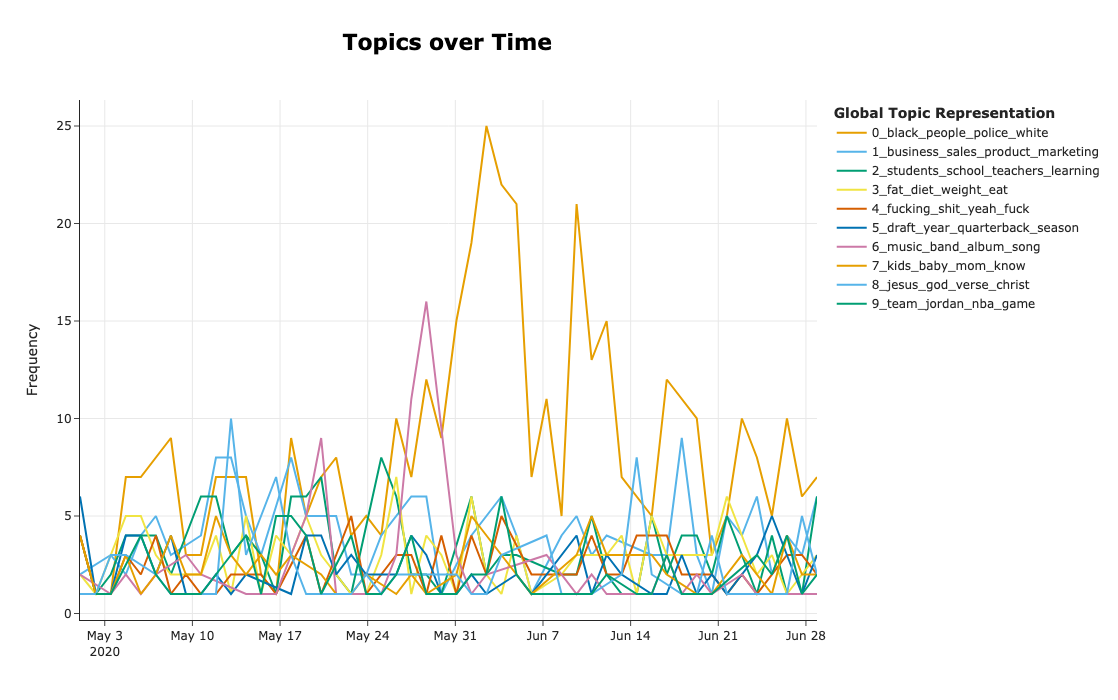

In [448]:
from bertopic import BERTopic

# Ensure your model is defined
topics_over_time = topic_model.topics_over_time(texts, timestamps,  nr_bins = 50)


# Get top 10 topics by 
top_topics = topic_info[topic_info.Topic != -1].head(10)['Topic']
filtered_topics_over_time = topics_over_time[topics_over_time['Topic'].isin(top_topics)]

# Visualize top topics over time
topic_model.visualize_topics_over_time(filtered_topics_over_time,  width=1050, height=700)


**5. Interoperability of Topics**

Inspecting the Topic List, top 10.


In [163]:
print(topic_info.head(10))


   Topic  Count                                 Name  \
0     -1   5276              -1_like_yeah_know_think   
1      0    426          0_black_people_police_white   
2      1    181   1_business_sales_product_marketing   
3      2    150  2_students_school_teachers_learning   
4      3    142                3_fat_diet_weight_eat   
5      4    104             4_fucking_shit_yeah_fuck   
6      5    100      5_draft_year_quarterback_season   
7      6     93              6_music_band_album_song   
8      7     90                 7_kids_baby_mom_know   
9      8     87             8_jesus_god_verse_christ   

                                      Representation  \
0  [like, yeah, know, think, going, one, people, ...   
1  [black, people, police, white, know, trump, li...   
2  [business, sales, product, marketing, people, ...   
3  [students, school, teachers, learning, educati...   
4  [fat, diet, weight, eat, keto, calories, eatin...   
5  [fucking, shit, yeah, fuck, like, oh, got, r

**6. Assign Topics to Documents**


In [451]:
episode_data['bertopic_topic'] = topics
episode_data['bertopic_prob'] = probs
episode_data.columns

Index(['transcript', 'rssUrl', 'epTitle', 'epDescription', 'mp3url',
       'podTitle', 'lastUpdate', 'itunesAuthor', 'itunesOwnerName', 'explicit',
       'imageUrl', 'language', 'createdOn', 'host', 'podDescription',
       'category1', 'category2', 'category3', 'category4', 'category5',
       'category6', 'category7', 'category8', 'category9', 'category10',
       'oldestEpisodeDate', 'episodeDateLocalized', 'durationSeconds',
       'hostPredictedNames', 'numUniqueHosts', 'guestPredictedNames',
       'numUniqueGuests', 'neitherPredictedNames', 'numUniqueNeithers',
       'mainEpSpeakers', 'numMainSpeakers', 'hostSpeakerLabels',
       'guestSpeakerLabels', 'overlapPropTurnCount', 'avgTurnDuration',
       'overlapPropDuration', 'totalSpLabels', 'cleaned_transcript',
       'dominant_topic', 'dominant_topic_label', 'combined_categories',
       'final_label', 'umap_x', 'umap_y', 'bertopic_topic', 'bertopic_prob'],
      dtype='object')

In [453]:
# Number of unique topics (including outliers if present)
unique_topics = set(topics)
print(f"Unique topics (including outliers): {len(unique_topics)}")

# Exclude outliers (-1)
unique_topics_no_outliers = [topic for topic in unique_topics if topic != -1]
print(f"Unique topics (excluding outliers): {len(unique_topics_no_outliers)}")


Unique topics (including outliers): 143
Unique topics (excluding outliers): 142


In [455]:
print(episode_data['bertopic_topic'].value_counts())


bertopic_topic
-1      5276
 0       426
 1       181
 2       150
 3       142
        ... 
 137      11
 138      11
 139      10
 140      10
 141      10
Name: count, Length: 143, dtype: int64


**6. Visualize Topic Distributions**

Plot the top topics by document count to see which ones dominate

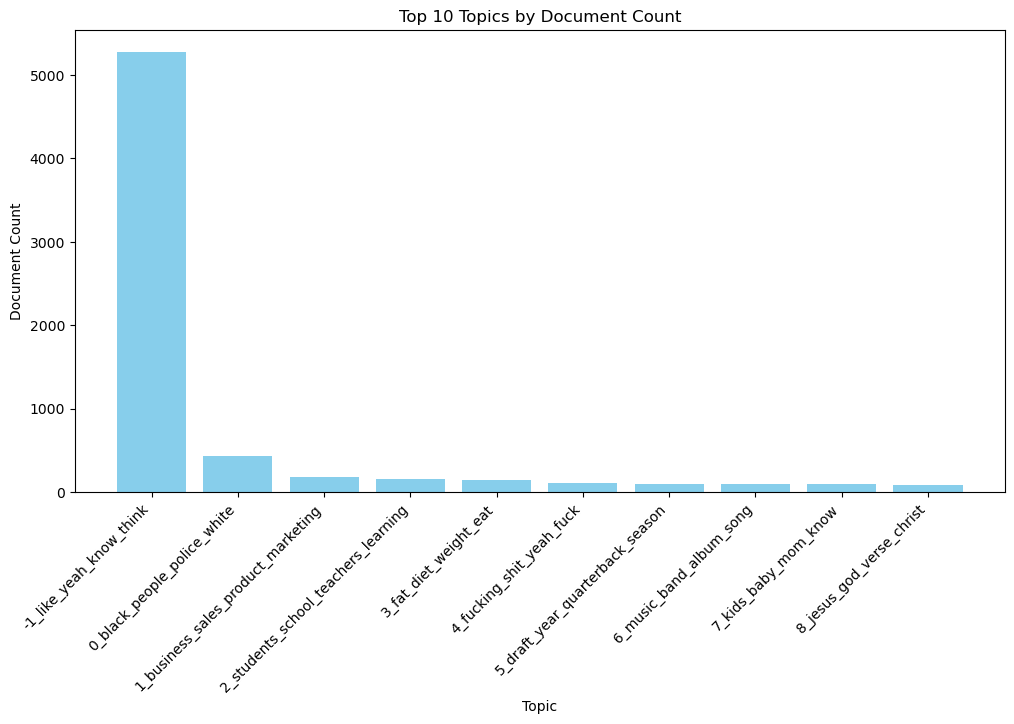

In [458]:
import matplotlib.pyplot as plt

plt.style.use('default')


topic_info_sorted = topic_info.sort_values(by="Count", ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(topic_info_sorted["Name"].head(10), topic_info_sorted["Count"].head(10), color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Topics by Document Count")
plt.xlabel("Topic")
plt.ylabel("Document Count")
plt.show()


**6. Filter out Topic -1**

Topic -1 (outliers) dominates our data (as stop words), excluding it will improve the quality of your analysis and visualizations for more better understanding of the context.

In [461]:
# Filter out Topic -1
episode_data_filtered = episode_data[episode_data['bertopic_topic'] != -1]

# Check the remaining dataset size
print(f"Original dataset size: {episode_data.shape[0]}")
print(f"Filtered dataset size: {episode_data_filtered.shape[0]}")


Original dataset size: 10000
Filtered dataset size: 4724


In [463]:
# Create a mapping of topic IDs to meaningful labels
topic_labels = topic_info.set_index('Topic')['Name'].to_dict()

# Replace topic IDs with their labels in the filtered dataset
episode_data_filtered['bertopic_label'] = episode_data_filtered['bertopic_topic'].map(topic_labels)


In [465]:
episode_data_filtered['bertopic_label'] 

2                   6_music_band_album_song
3                   6_music_band_album_song
4                   6_music_band_album_song
5       2_students_school_teachers_learning
6       2_students_school_teachers_learning
                       ...                 
9980              58_art_um_really_painting
9981              58_art_um_really_painting
9982              58_art_um_really_painting
9983              58_art_um_really_painting
9999            0_black_people_police_white
Name: bertopic_label, Length: 4724, dtype: object

**6. Reanalyze Topic Distributions**

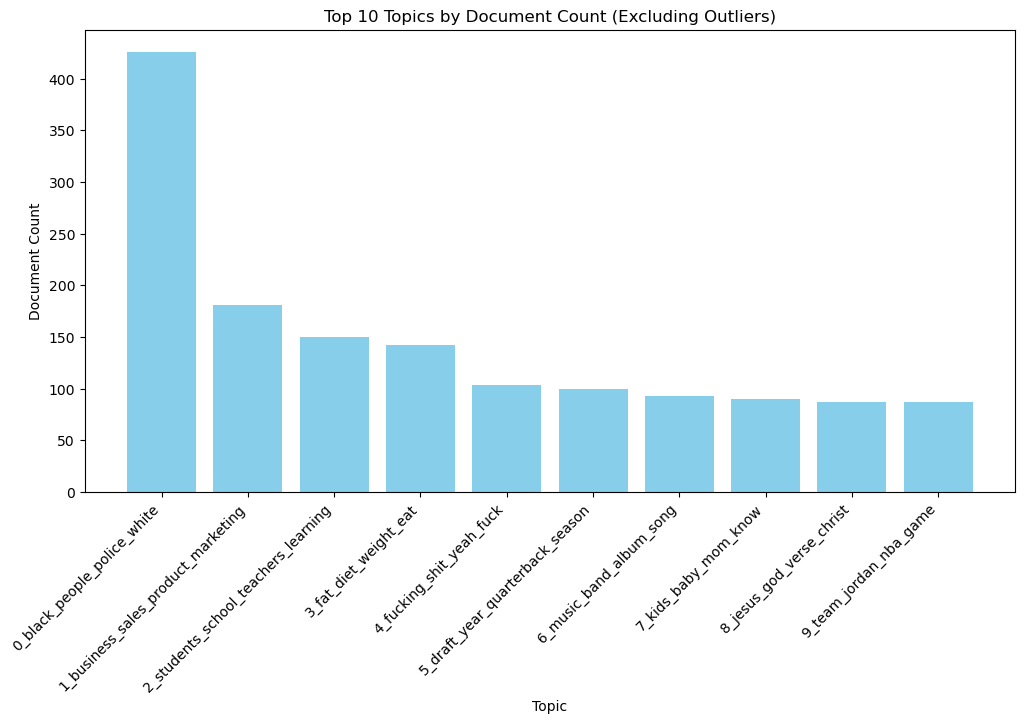

In [468]:
# Recalculate topic counts using the meaningful labels
filtered_topic_counts = episode_data_filtered['bertopic_label'].value_counts()

# Plot updated topic distribution
plt.figure(figsize=(12, 6))
plt.bar(filtered_topic_counts.index[:10], filtered_topic_counts.values[:10], color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Topics by Document Count (Excluding Outliers)")
plt.xlabel("Topic")
plt.ylabel("Document Count")
plt.show()


In [470]:
# Create meaningful labels from the topic names
topic_labels_short = {
    0: "BLM",
    1: "Business",
    2: "School",
    3: "Diet",
    4: "Slangs",
    5: "Sports",
    6: "Band",
    7: "Family",
    8: "Christianity",
    9: "NBA",
}

# Map the short labels to the dataset
episode_data_filtered['bertopic_label'] = episode_data_filtered['bertopic_topic'].map(topic_labels_short)


**7. Reanalyze Topic Distributions with More Meaningful Labels**

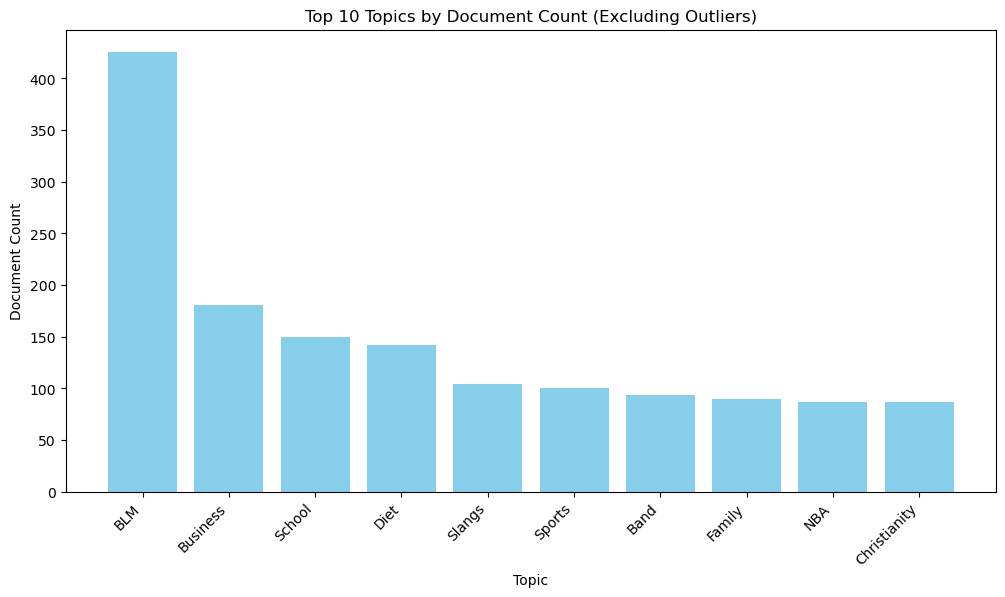

In [473]:
# Recalculate topic counts with meaningful labels
filtered_topic_counts = episode_data_filtered['bertopic_label'].value_counts()

# Plot the updated topic distribution
plt.figure(figsize=(12, 6))
plt.bar(filtered_topic_counts.index[:10], filtered_topic_counts.values[:10], color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Topics by Document Count (Excluding Outliers)")
plt.xlabel("Topic")
plt.ylabel("Document Count")
plt.show()


**8. Merge with Metadata**

* Compare BERTopic topics with `category1` to validate topic alignment:

In [476]:
topic_metadata_crosstab = pd.crosstab(
    episode_data['category1'],
    episode_data_filtered['bertopic_topic']
)
print(topic_metadata_crosstab)


bertopic_topic  0    1    2    3    4    5    6    7    8    9    ...  132  \
category1                                                         ...        
Unknown           0    0    0    0    0    0    0    0    0    0  ...    0   
arts              8    1    4    3    6    0    3    1    1    2  ...    0   
business         30  155   11    2    1    1    2   16    0    1  ...    0   
comedy           15    0    3    0   49    0    1    0    0    3  ...    2   
education        35    8   99   11    2    0    3   11    2    2  ...    0   
fiction           0    0    0    0    2    0    0    0    0    0  ...    0   
games             0    0    0    0    0    0    0    0    0    0  ...    0   
government       10    0    0    0    2    0    0    0    0    0  ...    0   
health           15    8    3  118    0    0    1   16    0    0  ...    1   
history           7    0    0    0    0    0    0    0    0    0  ...    0   
kids              1    0    6    0    1    0    0   37    0    0

**9. Visualize Alignment**

* Create a heatmap to visualize the alignment between category1 and BertTopic Topics:

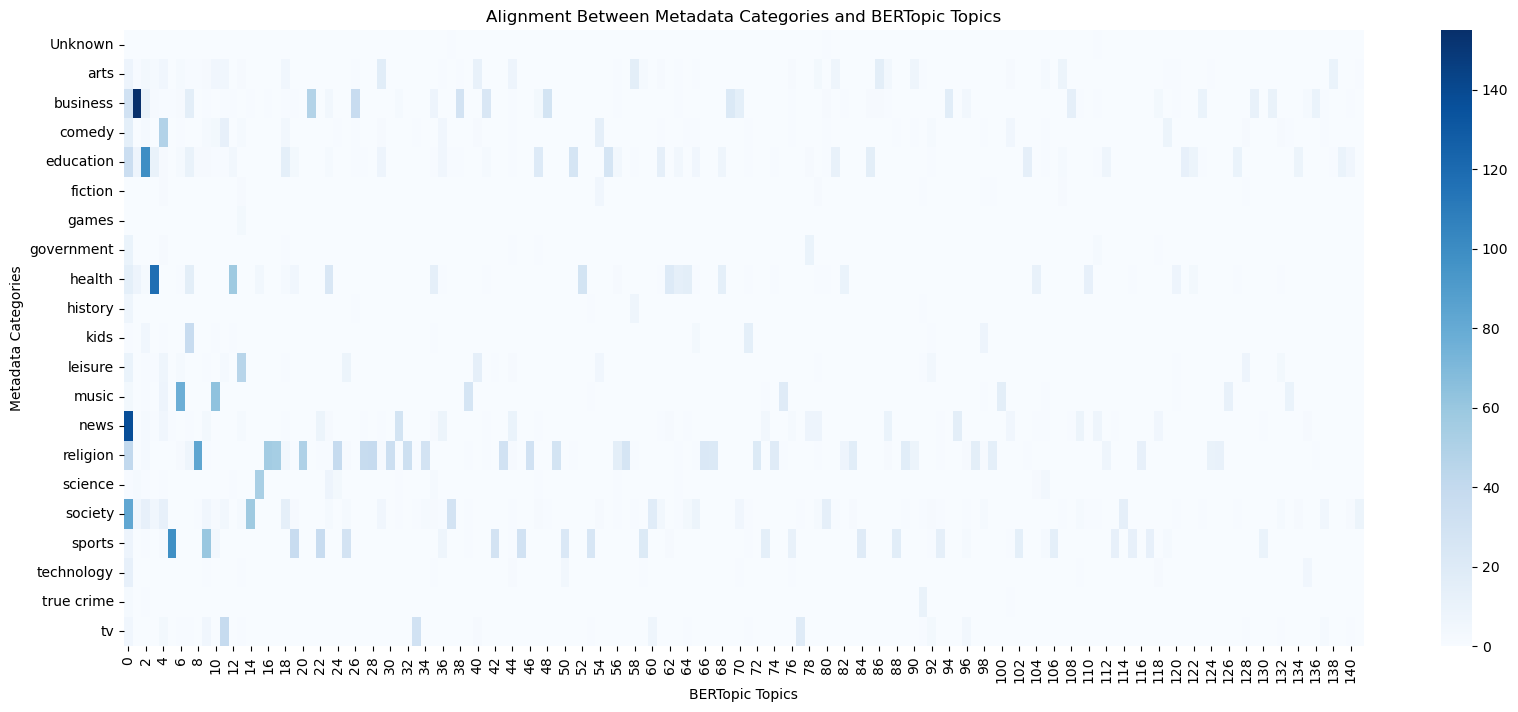

In [479]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 8))
sns.heatmap(topic_metadata_crosstab, cmap="Blues", annot=False, cbar=True)
plt.title("Alignment Between Metadata Categories and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("Metadata Categories")
plt.show()


**10. Identify dominant topics for each metadata category:**


In [482]:
dominant_topics = topic_metadata_crosstab.idxmax(axis=1)
print("Dominant Topic for Each Metadata Category:")
print(dominant_topics)


Dominant Topic for Each Metadata Category:
category1
Unknown       37
arts          29
business       1
comedy         4
education      2
fiction       54
games         13
government     0
health         3
history        0
kids           7
leisure       13
music          6
news           0
religion       8
science       15
society        0
sports         5
technology     0
true crime    91
tv            11
dtype: int64


In [484]:
alignment_strength = topic_metadata_crosstab.max(axis=1) / topic_metadata_crosstab.sum(axis=1)
print("Alignment Strength for Metadata Categories:")
print(alignment_strength)


Alignment Strength for Metadata Categories:
category1
Unknown       0.333333
arts          0.092896
business      0.281307
comedy        0.310127
education     0.217105
fiction       0.333333
games         1.000000
government    0.344828
health        0.278302
history       0.411765
kids          0.486842
leisure       0.368000
music         0.316872
news          0.440514
religion      0.094104
science       0.616279
society       0.211340
sports        0.167808
technology    0.371429
true crime    0.687500
tv            0.288889
dtype: float64


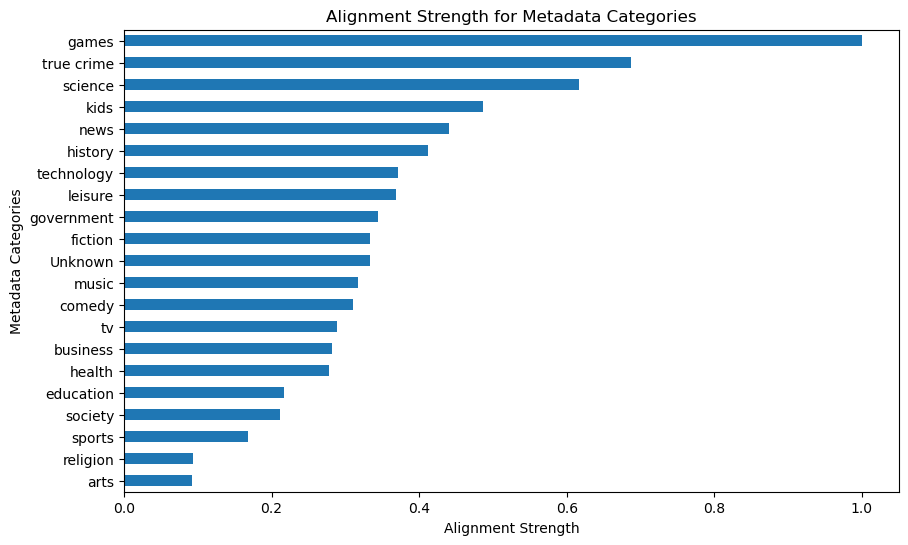

In [486]:
alignment_strength.sort_values().plot(kind='barh', figsize=(10, 6), title="Alignment Strength for Metadata Categories")
plt.xlabel("Alignment Strength")
plt.ylabel("Metadata Categories")
plt.show()


## Calculating Coherence Scores for LDA and BERTopic

* Tokenized corpus (list of lists of words).
* Dictionary mapping words to unique IDs (from `gensim`).


#### Step 1: Prepare Data for Coherence Calculation

Coherence scores evaluate the semantic consistency of topics in a model. Common methods include **c_v**, **u_mass**, and **c_npmi**, which can be calculated using the `gensim` library.



In [488]:
# Tokenized corpus (assume texts are preprocessed)
tokenized_corpus = [text.split() for text in episode_data['cleaned_transcript'] if isinstance(text, str)]

# Create dictionary and corpus for gensim
dictionary = corpora.Dictionary(tokenized_corpus)
corpus = [dictionary.doc2bow(text) for text in tokenized_corpus]

#### Step 2: Coherence for LDA

For the LDA model, extract the topics and compute coherence.


In [208]:
from gensim.models import CoherenceModel

# Prepare topics from LDA
lda_topics = [
    [word for word in term_topic_matrix[f"topic_{i}"].nlargest(10).index.tolist()]
    for i in range(lda.n_components)
]

# Compute coherence score for LDA
lda_coherence_model = CoherenceModel(
    topics=lda_topics,
    texts=tokenized_corpus,
    dictionary=dictionary,
    coherence="c_v"  # Use 'c_v' or 'u_mass'
)
lda_coherence = lda_coherence_model.get_coherence()

print(f"LDA Coherence Score: {lda_coherence}")


LDA Coherence Score: 0.5511276162857077


### Step 3: Coherence for BERTopic

For BERTopic, use the built-in `get_topic` method to extract topics.

#### Coherence Types

**c_v:**

* Measures the semantic coherence of top words in a topic using a sliding window and normalized pointwise mutual information.
* Focuses on human interpretability of the identified topics. 
* Generally considered a good balance between interpretability and computational cost.

**u_mass:**

* Measures coherence based on co-occurrence probability. 
* Less interpretable than c_v but computationally more efficient.

**c_npmi:**

* Captures the normalized pointwise mutual information for word pairs within a topic. 
* Provides a measure of semantic similarity between words within a topic.

In [491]:
# Prepare topics from BERTopic
bertopic_topics = [
    [word[0] for word in topic_model.get_topic(topic)]
    for topic in topic_model.get_topic_freq().head(10).Topic
    if topic != -1
]

# Compute coherence score for BERTopic
bertopic_coherence_model = CoherenceModel(
    topics=bertopic_topics,
    texts=tokenized_corpus,
    dictionary=dictionary,
    coherence="c_v"  # Use 'c_v' or 'u_mass'
)
bertopic_coherence = bertopic_coherence_model.get_coherence()

print(f"BERTopic Coherence Score: {bertopic_coherence}")


BERTopic Coherence Score: 0.6288290967737207


### Model Comparison: LDA vs. BERTopic

LDA achieved a moderate coherence score of 0.55, suggesting room for improvement. In contrast, BERTopic outperformed LDA with a coherence score of 0.63, reflecting more meaningful and coherent topics. 

The better score from BERTopic indicates the strength of BERTopic's transformer-based embeddings in capturing nuanced relationships within the dataset. Overall, BERTopic proved to be the more effective model for this task.

### Appendix A: Topic Analysis Summary Generation

The table summarizing the topic analysis has been displaye. This table will be used as part of the appendix in the paper to provide detailed insights into topics, their representative words, entropy of category distribution, and average category proportions.

In [569]:
print(episode_data.columns)


Index(['transcript', 'rssUrl', 'epTitle', 'epDescription', 'mp3url',
       'podTitle', 'lastUpdate', 'itunesAuthor', 'itunesOwnerName', 'explicit',
       'imageUrl', 'language', 'createdOn', 'host', 'podDescription',
       'category1', 'category2', 'category3', 'category4', 'category5',
       'category6', 'category7', 'category8', 'category9', 'category10',
       'oldestEpisodeDate', 'episodeDateLocalized', 'durationSeconds',
       'hostPredictedNames', 'numUniqueHosts', 'guestPredictedNames',
       'numUniqueGuests', 'neitherPredictedNames', 'numUniqueNeithers',
       'mainEpSpeakers', 'numMainSpeakers', 'hostSpeakerLabels',
       'guestSpeakerLabels', 'overlapPropTurnCount', 'avgTurnDuration',
       'overlapPropDuration', 'totalSpLabels', 'cleaned_transcript',
       'dominant_topic', 'dominant_topic_label', 'combined_categories',
       'final_label', 'umap_x', 'umap_y', 'bertopic_topic', 'bertopic_prob',
       'lda_topic_encoded', 'bertopic_topic_encoded', 'lda_topic_num

In [571]:
from scipy.stats import entropy

# Assuming `episode_data` contains the data with topics and categories
# Assuming `topic_model` is your trained BERTopic model

# Step 1: Extract top words for each topic
def extract_top_words(topic_model, n_words=10):
    top_words = {}
    for topic_num in topic_model.get_topics():
        if topic_num != -1:  # Skip outlier topics
            top_words[topic_num] = [word[0] for word in topic_model.get_topic(topic_num)[:n_words]]
    return top_words

# Step 2: Compute category-distribution entropy for each topic
def compute_entropy(df, category_col, topic_col):
    entropies = {}
    for topic in df[topic_col].unique():
        topic_data = df[df[topic_col] == topic]
        category_counts = topic_data[category_col].value_counts(normalize=True)
        entropies[topic] = entropy(category_counts)
    return entropies

# Step 3: Compute average category proportion for each topic
def compute_avg_category_proportion(df, category_col, topic_col):
    avg_category_props = {}
    for topic in df[topic_col].unique():
        topic_data = df[df[topic_col] == topic]
        avg_category_props[topic] = topic_data[category_col].value_counts(normalize=True).mean()
    return avg_category_props

# Step 4: Combine into a DataFrame
def generate_topic_table(df, topic_model, category_col, topic_col, n_words=10):
    top_words = extract_top_words(topic_model, n_words=n_words)
    entropies = compute_entropy(df, category_col, topic_col)
    avg_category_props = compute_avg_category_proportion(df, category_col, topic_col)

    topic_table = []
    for topic, words in top_words.items():
        topic_table.append({
            "Topic": topic,
            "Top Words": ", ".join(words),
            "Category Distribution Entropy": entropies.get(topic, np.nan),
            "Average Category Proportion": avg_category_props.get(topic, np.nan)
        })

    topic_df = pd.DataFrame(topic_table)
    return topic_df.sort_values(by="Average Category Proportion", ascending=False)

topic_table = generate_topic_table(
    df=episode_data,  # Your dataset with topics and categories
    topic_model=topic_model,  # Your trained BERTopic model
    category_col="category1",  # Adjust to your category column name
    topic_col="bertopic_topic",  # Use the correct topic column name
    n_words=10
)

# Display the resulting table
print(topic_table)

# Optionally, save to CSV
topic_table.to_csv("topic_analysis_table.csv", index=False)


    Topic                                          Top Words  \
94     94  imagination, salesman, enthusiasm, success, se...   
46     46  christ, paul, god, jesus, verse, us, says, chu...   
28     28  father, kingdom, love, able, us, know, god, sp...   
30     30  priesthood, elder, christ, restoration, nelson...   
97     97  church, jeff, god, jay, sermon, would, confess...   
..    ...                                                ...   
9       9  team, jordan, nba, game, player, players, play...   
44     44  farm, farmers, food, farmer, dairy, farms, pla...   
4       4  fucking, shit, yeah, fuck, like, oh, got, righ...   
2       2  students, school, teachers, learning, educatio...   
0       0  black, people, police, white, know, trump, lik...   

    Category Distribution Entropy  Average Category Proportion  
94                       0.000000                     1.000000  
46                       0.000000                     1.000000  
28                       0.000000   

In [573]:
episode_data[[ 
       'dominant_topic', 'dominant_topic_label', 'combined_categories',
       'final_label', 'umap_x', 'umap_y', 'bertopic_topic', 'bertopic_prob',
       'lda_topic_encoded', 'bertopic_topic_encoded']].iloc[0:3]

dominant_topic  dominant_topic_label  \
2        topic_7  Personal Development   
3        topic_7  Personal Development   
4        topic_7  Personal Development   

                                 combined_categories  \
2  music, society, culture, philosophy, education...   
3  music, society, culture, philosophy, education...   
4  music, society, culture, philosophy, education...   

                    final_label    umap_x     umap_y  bertopic_topic  \
2  music - Personal Development  2.605474   5.688138               6   
3  music - Personal Development  1.598043   6.370518               6   
4  music - Personal Development  1.180814  11.994482               6   

   bertopic_prob  lda_topic_encoded  bertopic_topic_encoded  
2       0.720302                  7                       7  
3       0.722604                  7                       7  
4       0.737274                  7                       7

In [575]:
episode_data_filtered['bertopic_topic']

2       6
3       6
4       6
5       2
6       2
       ..
9926    0
9938    0
9939    0
9968    5
9999    0
Name: bertopic_topic, Length: 1373, dtype: int64

### Compare LDA and BERTopic results and identify which topics have stronger correlations between the two models.

This will evaluate the overlap between the dominant topics assigned to each document by both models.




Mutual Information Score: 0.85
Cohen's Kappa: -0.07


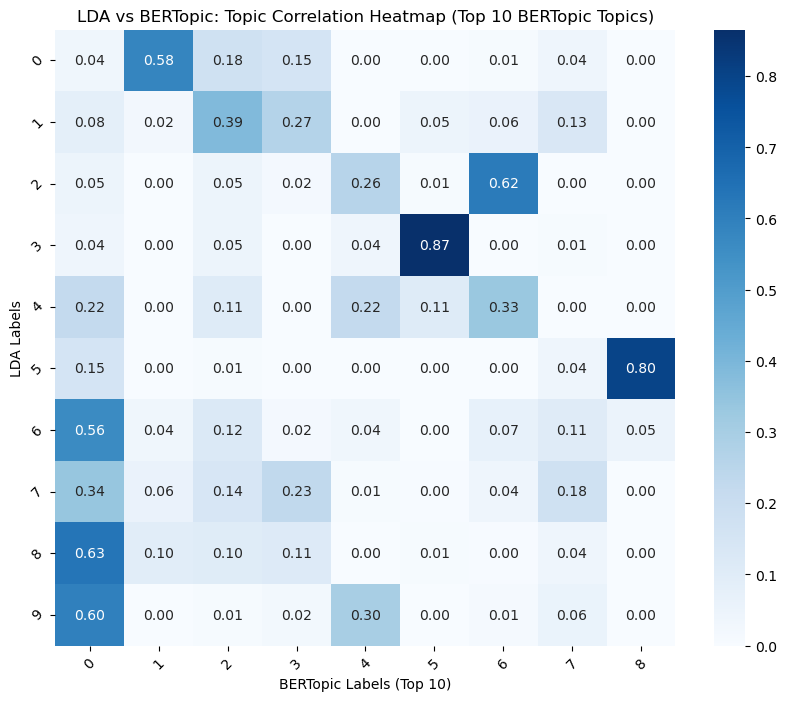

Topics with stronger correlations between LDA and BERTopic (Top 10 BERTopic Topics):
[3, 5]
Numerical Analysis of Heatmap Results
-------------------------------------
Strongest Correlations Per LDA Topic:
LDA Topic '0' → BERTopic '1': 0.58
LDA Topic '1' → BERTopic '2': 0.39
LDA Topic '2' → BERTopic '6': 0.62
LDA Topic '3' → BERTopic '5': 0.87
LDA Topic '4' → BERTopic '6': 0.33
LDA Topic '5' → BERTopic '8': 0.80
LDA Topic '6' → BERTopic '0': 0.56
LDA Topic '7' → BERTopic '0': 0.34
LDA Topic '8' → BERTopic '0': 0.63
LDA Topic '9' → BERTopic '0': 0.60

Average Correlation Across All Topics: 0.11
Number of Topics Above Threshold (0.73): 2


In [579]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Convert LDA's dominant_topic to numeric format
# Strip "topic_" prefix and convert to integers
episode_data['lda_topic_numeric'] = episode_data['dominant_topic'].str.replace("topic_", "").astype(int)

# Step 2: Ensure BERTopic topics are already numeric
# No changes needed as 'bertopic_topic' is numeric
episode_data = episode_data[episode_data['bertopic_topic'] != -1]


# Step 3: Filter the dataset to include only the top 10 BERTopic topics
top_10_bertopic_topics = topic_model.get_topic_freq().head(10)['Topic'].tolist()
episode_data_filtered = episode_data[episode_data['bertopic_topic'].isin(top_10_bertopic_topics)]

# Step 4: Encode topics for comparison
le_lda = LabelEncoder()
le_bertopic = LabelEncoder()

episode_data_filtered['lda_topic_encoded'] = le_lda.fit_transform(episode_data_filtered['lda_topic_numeric'])
episode_data_filtered['bertopic_topic_encoded'] = le_bertopic.fit_transform(episode_data_filtered['bertopic_topic'])

# Step 5: Calculate mutual information
mutual_info = mutual_info_score(
    episode_data_filtered['lda_topic_encoded'],
    episode_data_filtered['bertopic_topic_encoded']
)
print(f"Mutual Information Score: {mutual_info:.2f}")

# Step 6: Calculate Cohen's Kappa
kappa = cohen_kappa_score(
    episode_data_filtered['lda_topic_encoded'],
    episode_data_filtered['bertopic_topic_encoded']
)
print(f"Cohen's Kappa: {kappa:.2f}")

# Step 7: Generate and visualize confusion matrix
conf_matrix = pd.crosstab(
    episode_data_filtered['lda_topic_numeric'], 
    episode_data_filtered['bertopic_topic'], 
    normalize='index'
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("LDA vs BERTopic: Topic Correlation Heatmap (Top 10 BERTopic Topics)")
plt.xlabel("BERTopic Labels (Top 10)")
plt.ylabel("LDA Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Step 8: Identify topics with stronger correlations
correlation_threshold = 0.73  # Adjust as needed
strong_correlation_topics = conf_matrix[conf_matrix.max(axis=1) > correlation_threshold].index.tolist()
print("Topics with stronger correlations between LDA and BERTopic (Top 10 BERTopic Topics):")
print(strong_correlation_topics)

# Compute the strongest correlation values for each LDA topic
strongest_correlation_per_topic = conf_matrix.max(axis=1)

# Find the LDA-BERTopic pairs with the highest correlations
strongest_correlation_pairs = conf_matrix.idxmax(axis=1)

# Average correlation across all topic pairs
average_correlation = conf_matrix.to_numpy().mean()

# Count the number of LDA topics with correlations above a threshold
threshold = 0.73
topics_above_threshold = (strongest_correlation_per_topic > threshold).sum()

# Print results
print("Numerical Analysis of Heatmap Results")
print("-------------------------------------")
print("Strongest Correlations Per LDA Topic:")
for lda_topic, bert_topic, correlation in zip(
    conf_matrix.index, strongest_correlation_pairs, strongest_correlation_per_topic
):
    print(f"LDA Topic '{lda_topic}' → BERTopic '{bert_topic}': {correlation:.2f}")

print(f"\nAverage Correlation Across All Topics: {average_correlation:.2f}")
print(f"Number of Topics Above Threshold ({threshold}): {topics_above_threshold}")
